- 분석의 주제는 "고객별로 재구매할 상품"을 예측하는 것으로, 고객별로 특정 상품에 대해 어떤 특성(재구매여부 등)을 보이는지 파악해야함
- 고객의 특성, 상품의 특성을 전부 변수로 포함시켜보았으나, 결과적으로는 고객과 상품을 모두 고려한 변수가 가장 예측력이 높았기 때문에 해당 변수위주로 사용함

- 예측해야하는 최종 구매 데이터에서 재구매여부가 1(과거에 구매했던 이력이 있는)인 상품에 대해서만 특성을 파악할 수 있기 때문에 아래 세단계로 구분하여 분석을 진행함
    1. past 데이터 기준으로, 고객+상품 별 최종적으로 재구매가 이루어졌는지를 예측(1,0 binary)  -- Random Forest 사용
    2. 재구매한 상품들에 대해 add_order 매칭
    3. 고객별로 과거에 구매한 적 없었던 신규상품 매칭

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
import warnings 

warnings.filterwarnings(action = 'ignore')
pd.set_option('max_columns', 30)

from jbfg.pandas_utils import *

In [2]:
# 6개 데이터 읽어오기
products_info = get_df('select * from products_info', 'l2_jbwc_extnl')
train_x_past = get_df('select * from train_x_past', 'l2_jbwc_extnl')
train_x_current = get_df('select * from train_x_current', 'l2_jbwc_extnl')
train_y = get_df('select * from train_y', 'l2_jbwc_extnl')
test_x_past = get_df('select * from test_x_past', 'l2_jbwc_extnl')
test_x_current = get_df('select * from test_x_current', 'l2_jbwc_extnl')

원본데이터 보존을 위해 데이터셋에 대한 copy 생성

In [3]:
products_info_copy = products_info.copy()
train_x_past_copy = train_x_past.copy()
train_x_current_copy = train_x_current.copy()

# 1. 데이터살펴보기

## 1.1. products_info
- product_id : 상품ID
- name : 상품명
- category_id : 분류ID
- division_id : 담당부서ID
- category_name : 분류명
- division_name : 담당부서명

In [4]:
products_info_copy.shape

(100, 6)

In [5]:
products_info_copy.nunique()

product_id       100
name             100
category_id       21
division_id        9
category_name     21
division_name      9
dtype: int64

-> product_id, name 중복 없음 확인

In [6]:
products_info_copy[['division_name','category_name']].value_counts().sort_index()

division_name  category_name                
bakery         bread                             1
beverages      refrigerated                      1
               soft drinks                       1
               water seltzer sparkling water     5
canned goods   canned meals beans                1
dairy eggs     butter                            2
               cream                             2
               eggs                              2
               milk                              5
               packaged cheese                   4
               soy lactosefree                   3
deli           fresh dips tapenades              1
               lunch meat                        1
frozen         frozen produce                    2
meat seafood   packaged poultry                  1
pantry         oils vinegars                     1
produce        fresh fruits                     24
               fresh herbs                       3
               fresh vegetables      

-> 기존에 컬럼값이 밀려 이상치로 보였던 Clemetines Bag이 정상적으로 수정된 것을 확인함.

---

## 1.2. train_dataset

### 1.2.1. train_x_past: 5,859 고객들의 "과거"구매이력

- order id : 주문 id
- cstno: 고객id
- order_number: 고객별 주문서 순번(구매 일자별 순번)
- week_day: 구매요일(0 일요일)
- order_hour: 구매 시각
- order_interval: 직전 구매후 경과 일수
- add_order: 주문서 내 담긴 상품의 순번(구매 시 상품을 담은 순번)
- is_reordered: 재구매 여부
- product_id: 상품 id

In [7]:
train_x_past_copy.head(3)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3.0,5,0,41220
1,2325772,196613,35,6,11,2.0,7,1,41220
2,642668,196613,69,2,16,2.0,11,1,4210


In [8]:
train_x_past_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  object
 3   week_day        1253972 non-null  object
 4   order_hour      1253972 non-null  object
 5   order_interval  1253972 non-null  object
 6   add_order       1253972 non-null  object
 7   is_reordered    1253972 non-null  object
 8   product_id      1253972 non-null  object
dtypes: object(9)
memory usage: 86.1+ MB


In [9]:
train_x_past_copy.shape

(1253972, 9)

In [10]:
train_x_past_copy.describe()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
count,1253972,1253972,1253972,1253972,1253972,1253972,1253972,1253972,1253972
unique,341678,5859,99,7,24,32,93,2,100
top,2538975,150840,1,0,10,7.0,1,1,24852
freq,26,795,21686,233220,111896,166085,133657,1083774,74686


### 1.2.2. train_x_current: 5,859 고객들의 "현재" 구매 정보 (product_id제외)

- order id : 주문 id
- cstno: 고객id
- order_number: 고객별 주문서 순번(구매 일자별 순번)
- week_day: 구매요일(0 일요일)
- order_hour: 구매 시각
- order_interval: 직전 구매후 경과 일수
- add_order: 주문서 내 담긴 상품의 순번(구매 시 상품을 담은 순번)
- is_reordered: 재구매 여부

In [11]:
train_x_current_copy.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
0,806422,41116,47,5,18,3.0,4,1
1,2146033,127113,45,1,10,7.0,24,1
2,3055498,140168,45,5,10,26.0,11,1
3,3267527,60604,52,0,16,8.0,2,1
4,3125992,136554,46,4,9,5.0,2,0


In [12]:
train_x_current_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        24424 non-null  object
 1   cstno           24424 non-null  object
 2   order_number    24424 non-null  object
 3   week_day        24424 non-null  object
 4   order_hour      24424 non-null  object
 5   order_interval  24424 non-null  object
 6   add_order       24424 non-null  object
 7   is_reordered    24424 non-null  object
dtypes: object(8)
memory usage: 1.5+ MB


In [13]:
train_x_current_copy.shape

(24424, 8)

In [14]:
train_x_current_copy.describe()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
count,24424,24424,24424,24424,24424,24424,24424,24424
unique,5859,5859,58,7,24,31,55,2
top,736120,148812,100,0,10,7.0,2,1
freq,24,24,2060,6806,2002,3825,2404,22987


train_x_current 데이터 "현재"의 정의는? => 한 고객번호 예시로 파악해보기

In [15]:
train_x_past_copy.loc[train_x_past_copy['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
57,1175721,196613,1,6,13,,10,0,24184
185,1175721,196613,1,6,13,,8,0,24852
112,1175721,196613,1,6,13,,5,0,17794
197,2914937,196613,11,6,10,1.0,5,1,24852
31,2914937,196613,11,6,10,1.0,11,0,46906
...,...,...,...,...,...,...,...,...,...
5,185079,196613,94,6,17,6.0,1,1,38689
173,185079,196613,94,6,17,6.0,3,1,24852
118,185079,196613,94,6,17,6.0,6,0,37646
135,564940,196613,97,6,15,5.0,1,1,27966


In [16]:
train_x_current_copy.loc[train_x_current_copy['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
1632,2414402,196613,100,6,13,5.0,4,1
24170,2414402,196613,100,6,13,5.0,1,1


-> train_x_current 데이터는 5,859명 고객의 가장 마지막 주문번호 "한 건"에 대한 정보로 보여짐. <br>
<br>
다만 order_number 값이 연속적이지 않으므로 train_x_past의 order_number 값 자체가 중간에 누락이 있는지 먼저 확인 필요<br>

    - train_x_past의 order_number가 string타입이므로 일부 컬럼에 대한 타입 변경 먼저 진행, 타입변경 함수 생성

In [17]:
def type_change(df, col, to_type):
    #docstring
    '''dataframe, type변경할 컬럼명, 변경할 타입 입력'''
    df[col] = df[col].astype(to_type)

In [18]:
type_change(train_x_past_copy, ['order_number','order_hour','add_order'], 'int')
type_change(train_x_current_copy, ['order_number','order_hour','add_order'], 'int')

    → 타입 변경 완료 
       (order interval은 int로 타입 변경 시, 오류가 발생하므로 뒤에서 별도로 수정 필요)

order_number 중간 누락 확인을 위해 고객별 order_number최댓값과, 고유값의 count값을 대조

In [19]:
train_x_past_copy.groupby('cstno')['order_number'].max() == train_x_past_copy.groupby('cstno')['order_number'].nunique()

cstno
10000     False
100001    False
100046    False
100071    False
100108    False
          ...  
9981      False
99829      True
99887     False
99894      True
99901      True
Name: order_number, Length: 5859, dtype: bool

-> train_x_past의 order_number 자체에 누락이 있는 것으로 확인됨

    - 1) train_x_current에 고객별 order_id가 unique한지 확인
    - 2) train_x_current의 order_number > train_x_past의 마지막 order_number 인지 확인

In [20]:
train_x_current_copy.groupby(['cstno','order_id']).nunique().sum()

order_number       5859
week_day           5859
order_hour         5859
order_interval     5859
add_order         24424
is_reordered       6917
dtype: int64

In [21]:
tmp = train_x_current_copy.groupby('cstno')['order_number'].min() > train_x_past_copy.groupby('cstno')['order_number'].max()

In [22]:
tmp[tmp.values == False]

Series([], Name: order_number, dtype: bool)

In [23]:
del(tmp)

-> 1), 2) 전부 확인 완료
   
    - train_x_current이 고객의 마지막 주문 정보를 의미하므로, train_x_past와 train_x_current를 합쳐서 가공하기로 함

In [24]:
# train_x_current와 train_y를 먼저 결함

train_current = pd.concat([train_x_current_copy,train_y], axis = 1)

# 먼저 past와 current 데이터에 last_order_yn 컬럼을 생성하여 두 dataset을 구분

train_x_past_copy['last_order_yn'] = 0
train_current['last_order_yn'] = 1

In [25]:
train_data = pd.concat([train_x_past_copy,train_current], axis = 0)

-> train dataset 결합 완료

In [26]:
train_data.sort_values(['cstno','order_number','add_order']).head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn
423552,1492646,10000,1,0,11,,1,0,21137,0
423390,1492646,10000,1,0,11,,3,0,5077,0
423511,1492646,10000,1,0,11,,4,0,47766,0
423454,1492646,10000,1,0,11,,7,0,27104,0
423418,1492646,10000,1,0,11,,8,0,26604,0
423501,1492646,10000,1,0,11,,10,0,22935,0
423306,1492646,10000,1,0,11,,12,0,15290,0
423597,1492646,10000,1,0,11,,13,0,24852,0
423527,1492646,10000,1,0,11,,19,0,21903,0
423288,1444722,10000,2,6,7,6.0,9,0,4799,0


## 1.3. train dataset 가공

In [27]:
# train_data도 가공 전에 copy

train_data_copy = train_data.copy()

In [28]:
# train_data_copy의 index도 초기화 (past+current 결합하면서 index 중복이 발생함)

train_data_copy.loc[0,:]

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn
0,717029,196613,15,1,9,3.0,5,0,41220,0
0,806422,41116,47,5,18,3.0,4,1,21709,1


In [29]:
# train_data_copy의 index도 초기화 (past+current 결합하면서 index 중복이 발생함)

train_data_copy.reset_index(drop = True, inplace= True)
train_data_copy.loc[0,:]

order_id          717029
cstno             196613
order_number          15
week_day               1
order_hour             9
order_interval       3.0
add_order              5
is_reordered           0
product_id         41220
last_order_yn          0
Name: 0, dtype: object

### 1.3.1. 컬럼가공

#### 1.3.1.1. colum요건 확인 및 가공

##### 1.3.1.1.1. add_order

In [30]:
train_data_copy.groupby(['cstno','order_id'])['add_order'].min()

cstno  order_id
10000  103998      3
       1090401     1
       1104652     2
       1125006     1
       1191621     2
                  ..
99901  712543      2
       748340      5
       774765      3
       919399      1
       921228      2
Name: add_order, Length: 347537, dtype: int64

    -> 고객별 min(add_order) 가 1이 아닌 것들도 있음 -> 장바구니에 넣고 구매는 하지 않은 것으로 추정됨
    고객/주문번호별로 add_order 1~n 새로 생성

In [31]:
def row_number(df, new_col, base_col, asc, agg_col):
    #docstring
    '''dataframe, new_col, base_col, asc, agg_col
    ex_train_x_past, 'cst_rn', ['order_number','add_order'], [True, True], 'cstno'
       df['cst_rn'] = df.sort_values(['order_number','add_order'], ascending=[True,True]).groupby('cstno').cumcount() + 1 '''
    #고객별 order 순서컬럼 생성(order_number + adj_add_order)
    df[new_col] = df.sort_values(base_col, ascending=asc).groupby(agg_col).cumcount() + 1    

In [32]:
row_number(train_data_copy, 'new_add_order','add_order', True, ['cstno','order_number'])

##### 1.3.1.1.2. order_number

train_x_past 데이터 확인할 때, order_number값이 중간에 누락이 있는 것을 확인함 <br>
order_number 재확인 필요

In [33]:
train_data_copy.groupby('cstno')['order_number'].max() == train_data_copy.groupby('cstno')['order_number'].nunique()

cstno
10000     False
100001    False
100046    False
100071    False
100108    False
          ...  
9981      False
99829      True
99887     False
99894      True
99901     False
Name: order_number, Length: 5859, dtype: bool

-> order_number 최댓값 != 갯수 → order_number도 중간에 누락 → 주문취소 등으로 추정됨<br>
order number 재설정

In [34]:
tmp_order_number_rn = train_data_copy[['cstno','order_id','order_number','add_order','new_add_order']].sort_values(['cstno','order_number','new_add_order'])
tmp_order_number_rn.reset_index(drop = True, inplace = True)

In [35]:
st = datetime.now()

new_orders = []
for idx, row in tmp_order_number_rn.iterrows():
    if idx == 0:
        new_order = 1
    elif prior_cstno != row['cstno']:
        new_order = 1
    elif prior_order_id == row['order_id']:
        new_order = prior_new_order_number
    else:
        new_order = prior_new_order_number + 1
    
    prior_cstno = row['cstno']
    prior_order_id = row['order_id']
    prior_new_order_number = new_order
    
    new_orders.append(new_order)

tmp_order_number_rn['new_order_number'] = new_orders    
print(datetime.now() - st)

0:01:32.045607


생성된 order_number를 train_x_past_copy와 조인

In [36]:
train_data_copy = pd.merge(left = train_data_copy, right = tmp_order_number_rn, how = 'left', on = ['cstno','order_id','order_number','add_order','new_add_order'])

In [37]:
del(tmp_order_number_rn)

##### 1.3.1.1.3. is_reordered

In [38]:
train_data_copy[train_data_copy['is_reordered'] == '0'].value_counts().sum()

171635

In [39]:
train_data_copy['tmp'] = train_data_copy['cstno'] + train_data_copy['order_number'].astype('str')
train_data_copy['tmp'].nunique()

346717

171,635 != 346,717<br>
→ 고객+주문번호별 아닌 것 확인

In [40]:
train_data_copy['tmp2'] = train_data_copy['cstno'] + train_data_copy['product_id']
train_data_copy['tmp2'].nunique()

171635

171,635 == 171,635 <br>
is_reordered : 고객 + 상품별 기준인 것 확인<br>

In [41]:
#필요없어진 tmp, tmp2 컬럼 제거

train_data_copy.drop(['tmp','tmp2'], axis=1, inplace=True)

##### 1.3.1.1.4. cst_rn 컬럼 생성

고객별 rn을 생성 -> 고객별 주문+상품 확인용

In [42]:
row_number(train_data_copy, 'cst_rn',['new_order_number','new_add_order'], [True,True], ['cstno'])

<br><br>



### 1.3.2. 데이터타입 변경
- order_interval int로 데이터타입 변경<br><br>
order_interval컬럼은 일부 float string 때문에 astype오류남 -> to_numeric으로 처리

In [43]:
train_data_copy['order_interval'] = pd.to_numeric(train_data_copy['order_interval'])

In [44]:
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278396 entries, 0 to 1278395
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   order_id          1278396 non-null  object 
 1   cstno             1278396 non-null  object 
 2   order_number      1278396 non-null  int64  
 3   week_day          1278396 non-null  object 
 4   order_hour        1278396 non-null  int64  
 5   order_interval    1256710 non-null  float64
 6   add_order         1278396 non-null  int64  
 7   is_reordered      1278396 non-null  object 
 8   product_id        1278396 non-null  object 
 9   last_order_yn     1278396 non-null  int64  
 10  new_add_order     1278396 non-null  int64  
 11  new_order_number  1278396 non-null  int64  
 12  cst_rn            1278396 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 136.5+ MB


float로 변경하면서 null 발생 -- 최초 주문 건에는 order_interval이 없기때문

order_interval결측치 처리<br>
원래 0으로 대체했었는데, 모형 테스트 중 동일 일자에 두번 구매한 고객의 order_interval == 0 확인함<br>
차이를 두기위해 -1로 변경

고객별로 order_number의 최솟값이 1이 아니면 order_interval이 null이 아님 -- new_order 가 아니라 원래 order_number기준으로 판단해야함

In [45]:
train_data_copy.loc[train_data_copy['order_number'] == 1, 'order_interval'] = -1

In [46]:
type_change(train_data_copy, 'order_interval','int')

<br><Br>

### 1.3.3. products_info와 merge

    - train_data_copy 데이터에 products_info 데이터 결합

In [47]:
train_data_copy = pd.merge(left = train_data_copy, right = products_info_copy, how = 'left', on = 'product_id')

In [48]:
train_data_copy[train_data_copy['cstno'] == '196613'].sort_values('cst_rn').head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,new_add_order,new_order_number,cst_rn,name,category_id,division_id,category_name,division_name
112,1175721,196613,1,6,13,-1,5,0,17794,0,1,1,1,Carrots,83,4,fresh vegetables,produce
185,1175721,196613,1,6,13,-1,8,0,24852,0,2,1,2,Banana,24,4,fresh fruits,produce
57,1175721,196613,1,6,13,-1,10,0,24184,0,3,1,3,Red Peppers,83,4,fresh vegetables,produce
63,388865,196613,2,6,14,0,4,0,19660,0,1,2,4,Spring Water,115,7,water seltzer sparkling water,beverages
51,388865,196613,2,6,14,0,5,0,46667,0,2,2,5,Organic Ginger Root,83,4,fresh vegetables,produce


→ train dataset 가공완료

가공완료된 train data 를 기존처럼 past, current 분리한 후 EDA 진행

In [49]:
train_new_past = train_data_copy.loc[train_data_copy['last_order_yn'] == 0]
train_new_current = train_data_copy.loc[train_data_copy['last_order_yn'] == 1]

---

# 2. EDA

In [50]:
train_new_past.head(3)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,new_add_order,new_order_number,cst_rn,name,category_id,division_id,category_name,division_name
0,717029,196613,15,1,9,3,5,0,41220,0,1,12,34,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,35,6,11,2,7,1,41220,0,2,26,86,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,69,2,16,2,11,1,4210,0,3,53,163,Whole Milk,84,16,milk,dairy eggs


In [51]:
# int형 reorder 컬럼생성 - reorder 집계용

train_new_past['is_reordered_int'] = train_new_past['is_reordered'].astype('int')

## 2.1. 구매현황

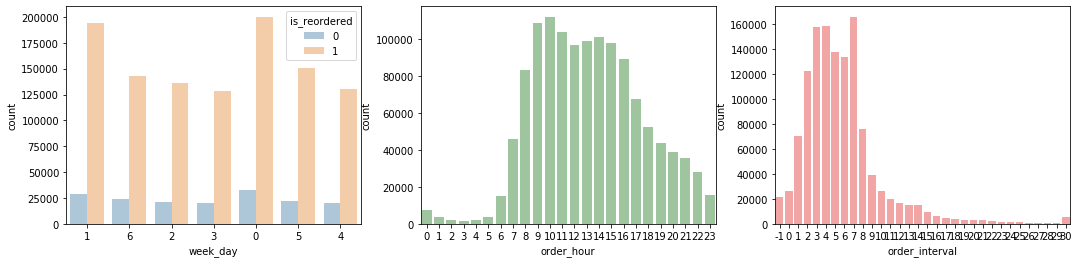

In [319]:
fig, ax = plt.subplots(1,3, figsize = (18,4))
ax = ax.ravel()

sns.countplot(ax =ax[0], x = train_new_past['week_day'], hue = train_new_past['is_reordered'], alpha = 0.4)
sns.countplot(ax = ax[1], x = train_new_past['order_hour'], color = 'green', alpha = 0.4)
sns.countplot(ax =ax[2], x = train_new_past['order_interval'], color = 'red', alpha = 0.4)

plt.show()

### 2.1.1. week_day 기준

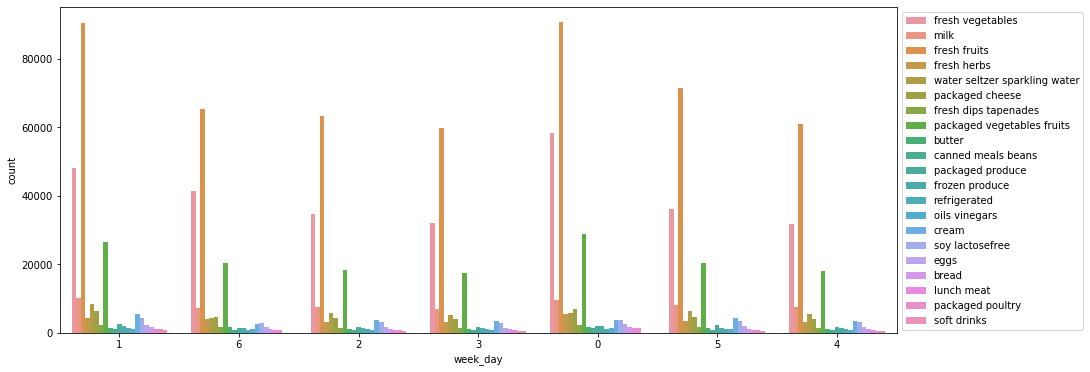

In [53]:
# 총 구매횟수 기준
fig, axes = plt.subplots(figsize = (15,6))

sns.countplot(ax = axes, x = 'week_day', hue = 'category_name', data = train_new_past)
plt.legend(loc = 2, bbox_to_anchor = (1,1))

plt.show()

-> fresh vegetables, fresh fruits, packaged vegetables fruits의 주문 비중이 매우 큼. 과일/야채류를 자주 주문하는 것으로 보임

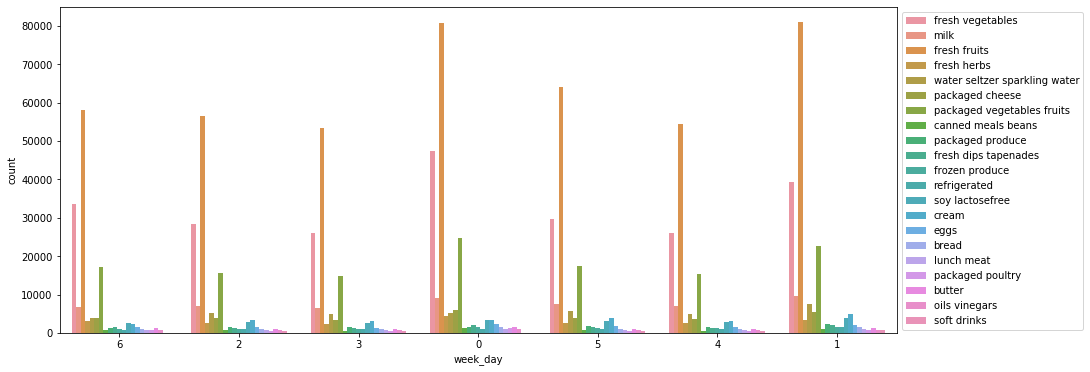

In [54]:
# 재구매기준
fig, axes = plt.subplots(figsize = (15,6))

sns.countplot(ax = axes, x = 'week_day', hue = 'category_name', data = train_new_past.loc[train_new_past['is_reordered']=='1'])
plt.legend(loc = 2, bbox_to_anchor = (1,1))

plt.show()

-> 재주문도 동일하게 fresh vegetables, fresh fruits, packaged vegetables fruits의 주문 비중이 매우 큼

비중이 높은 fresh_vege, fresh_fruits 제외하고 요일별 총 구매횟수 확인

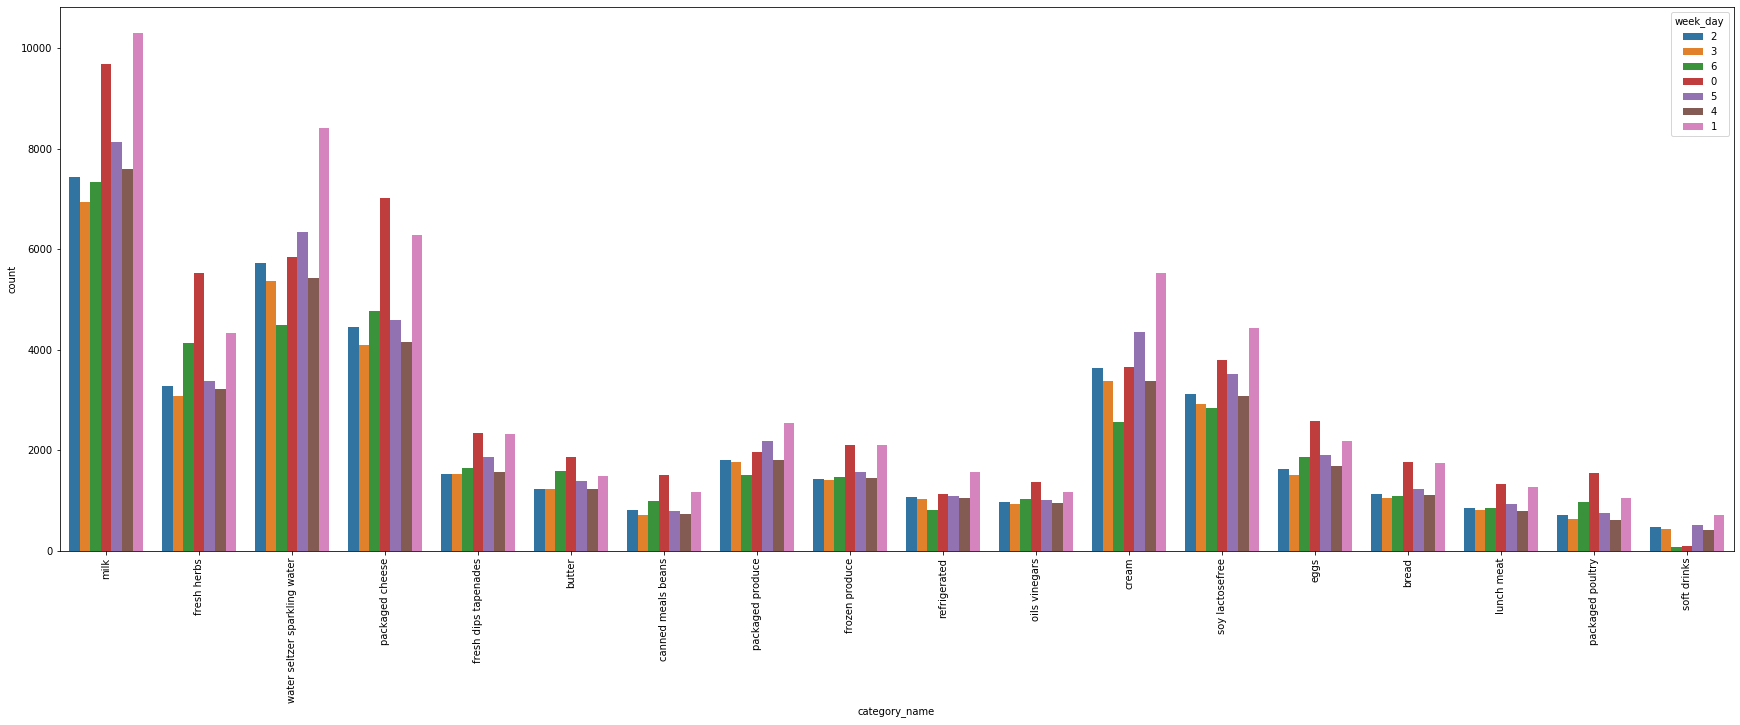

In [55]:
fig, axes = plt.subplots(figsize = (30,10))
# ax = ax.ravel()

sns.countplot(ax = axes, x = 'category_name',hue = 'week_day', data = train_new_past.loc[(train_new_past['category_name'] != 'fresh vegetables') & (train_new_past['category_name'] != 'fresh fruits')& (train_new_past['category_name'] != 'packaged vegetables fruits')])
plt.xticks(rotation = 90)
# plt.legend(loc = 2, bbox_to_anchor = (1,1))

plt.show()

-> 모든 카테고리의 최대 구매횟수가 포함된 요일이 일요일 or 월요일이기 때문에 요일이 큰 의미가 있어보이지는 않음

### 2.1.2. order hour기준

In [56]:
hour_tmp = train_new_past.groupby(['cstno','name'])['order_hour'].mean()

In [57]:
hour_tmp = pd.DataFrame(hour_tmp)
hour_tmp.reset_index(inplace = True)
hour_tmp.head()

,cstno,name,order_hour
0,10000,100% Whole Wheat Bread,10.341463
1,10000,Bag of Organic Bananas,12.000000
2,10000,Banana,10.500000
3,10000,Carrots,13.250000
4,10000,Extra Virgin Olive Oil,9.500000


In [58]:
hour_tmp.groupby('name').mean()['order_hour'].astype('int').unique()

array([13, 12])

In [59]:
hour_tmp.groupby('cstno').mean()['order_hour'].astype('int').unique()

array([11, 13, 14, 12, 10, 15, 17,  9, 16,  7,  8, 18, 19, 20,  3, 22])

상품별로는 주문시간에 차이가 없으나 고객별로는 차이가 있음 -> 고객 특성테이블 생성

## 2.2.고객별 주문현황 (고객 특성 테이블 생성)

### 2.2.1. 고객별 주문 시간

    - 고객별 평균 주문 시간 확인 (mean_order_hour)

In [60]:
cst_feature_info = pd.DataFrame(hour_tmp.groupby('cstno').mean()['order_hour'])
cst_feature_info.reset_index(inplace = True)
cst_feature_info.rename(columns = {'order_hour' : 'mean_order_hour'}, inplace = True)

In [61]:
cst_feature_info.head(3)

,cstno,mean_order_hour
0,10000,11.710890
1,100001,13.343696
2,100046,14.943764


    - 고객별 최다 주문 시간 확인 (mode_cst_hour)

In [62]:
hour_mode = train_new_past[['cstno','order_hour']].value_counts()
hour_mode = pd.DataFrame(hour_mode)
hour_mode.reset_index(inplace = True)

In [63]:
row_number(hour_mode, 'rn', 0, False, 'cstno')

In [64]:
hour_mode = hour_mode[hour_mode['rn'] == 1]

In [65]:
cst_feature_info = cst_feature_info.merge(hour_mode[['cstno','order_hour']], on = 'cstno')
cst_feature_info.rename(columns = {'order_hour':'mode_cst_hour'}, inplace = True)
cst_feature_info.head()

,cstno,mean_order_hour,mode_cst_hour
0,10000,11.710890,8
1,100001,13.343696,10
2,100046,14.943764,16
3,100071,13.519928,16
4,100108,11.967736,12


In [66]:
del(hour_tmp, hour_mode)

### 2.2.2. 고객별 주문건수

    - 고객별 주문건수 확인 (cst_orders_cnt)

In [67]:
# 전 고객 평균 주문 건수
mean_order_cnt = train_new_past.groupby('cstno')['order_number'].max().mean()

print(mean_order_cnt)

65.27410820959209


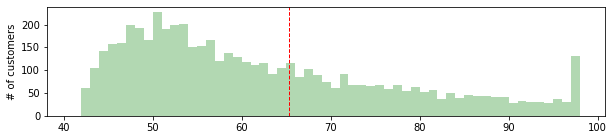

In [68]:
orders_per_cst = train_new_past.groupby('cstno')['order_number'].max()

fig, ax = plt.subplots(1,1, figsize=(10,2))

ax.hist(x = orders_per_cst, bins = range(orders_per_cst.min()-1, orders_per_cst.max(),1), color = 'green', alpha = 0.3)
ax.set_ylabel('# of customers')
ax.axvline(mean_order_cnt, color = 'r', linestyle = 'dashed', linewidth = 1)

고객별 주문 건수

In [69]:
cst_feature_info = cst_feature_info.sort_values('cstno')
cst_feature_info['cst_orders_cnt'] = orders_per_cst.sort_index().values

In [70]:
cst_feature_info.head()

,cstno,mean_order_hour,mode_cst_hour,cst_orders_cnt
0,10000,11.710890,8,72
1,100001,13.343696,10,66
2,100046,14.943764,16,65
3,100071,13.519928,16,53
4,100108,11.967736,12,70


### 2.2.3. 고객,주문별 평균 구매상품건수

    - 고객별 총 주문 건수 확인 (totl_prod_cnt_per_order)
    - 고객별 주문 당 평균 구매상품 건수 확인 (mean_prod_cnt_per_order)

In [71]:
order_cnt = train_new_past['order_id'].nunique()
mean_product_cnt = train_new_past.groupby(['cstno','order_id'])['add_order'].max().mean()

print(order_cnt, mean_product_cnt)

341678 9.493113399165296


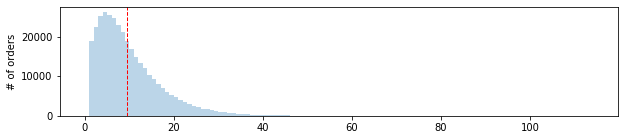

In [72]:
product_per_order = train_new_past.groupby(['cstno','order_id'])['add_order'].max()

fig, ax = plt.subplots(1,1, figsize=(10,2))

ax.hist(x = product_per_order, bins = range(product_per_order.min()-1, product_per_order.max(),1), alpha = 0.3)
ax.set_ylabel('# of orders')
ax.axvline(mean_product_cnt, color = 'r', linestyle = 'dashed', linewidth = 1)

In [73]:
product_per_order = pd.DataFrame(product_per_order)
product_per_order = product_per_order.reset_index()
product_per_order.head()

,cstno,order_id,add_order
0,10000,103998,11
1,10000,1090401,9
2,10000,1104652,14
3,10000,1125006,18
4,10000,1191621,25


In [74]:
cst_feature_info = cst_feature_info.sort_values('cstno')
cst_feature_info['totl_prod_cnt_per_order'] = product_per_order.groupby('cstno')['add_order'].max().sort_index().values
cst_feature_info['mean_prod_cnt_per_order'] = product_per_order.groupby('cstno')['add_order'].mean().sort_index().values
cst_feature_info.head()

,cstno,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order
0,10000,11.710890,8,72,36,13.257576
1,100001,13.343696,10,66,23,9.952381
2,100046,14.943764,16,65,28,10.580645
3,100071,13.519928,16,53,23,9.764706
4,100108,11.967736,12,70,17,5.682540


### 2.2.4. 고객별 재주문 현황

- is_reordered 컬럼은 cstno + product_id 기준
    - 고객별로 평소 동일한 상품을 반복해서 구매하는지, 새로운 상품을 구매하는지 파악

    - 고객별 상품 재구매율 확인 (cst_reorder_ratio) : 고객이 재구매한 상품 개수 / 고객이 구매한 전체 상품 개수

In [75]:
reorder_tmp = train_new_past.loc[train_new_past['is_reordered'] == '1'].groupby('cstno')['product_id'].nunique() / train_new_past.groupby('cstno')['product_id'].nunique()
reorder_tmp = pd.DataFrame(reorder_tmp)
reorder_tmp.reset_index(inplace = True)
reorder_tmp.rename(columns = {'product_id':'cst_reorder_ratio'}, inplace = True)

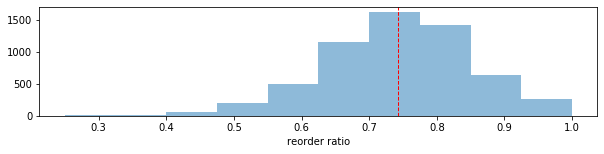

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

ax.hist(reorder_tmp['cst_reorder_ratio'], alpha=0.5)
ax.set_xlabel('reorder ratio')
ax.axvline(reorder_tmp['cst_reorder_ratio'].mean(), color = 'r', linestyle='dashed', linewidth=1)

In [77]:
cst_feature_info = cst_feature_info.merge(reorder_tmp, on = 'cstno')
cst_feature_info.head()

,cstno,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio
0,10000,11.710890,8,72,36,13.257576,0.659091
1,100001,13.343696,10,66,23,9.952381,0.775000
2,100046,14.943764,16,65,28,10.580645,0.727273
3,100071,13.519928,16,53,23,9.764706,0.888889
4,100108,11.967736,12,70,17,5.682540,0.772727


In [78]:
del(reorder_tmp)

### 2.2.5. 고객별 주문간격

    - 고객별 평균 주문간격 확인 (cst_order_interval)

In [79]:
# order interval을 -1로 설정한 첫번째 주문 건 제외

order_interval_tmp = train_new_past.loc[train_new_past['order_number'] != 1].groupby(['cstno','order_id'])['order_interval'].mean()
order_interval_tmp = order_interval_tmp.groupby('cstno').mean()
order_interval_tmp

cstno
10000     4.707692
100001    5.467742
100046    4.704918
100071    5.560000
100108    5.238095
            ...   
9981      7.276596
99829     8.523810
99887     3.965909
99894     7.000000
99901     7.543478
Name: order_interval, Length: 5859, dtype: float64

In [80]:
order_interval_tmp = pd.DataFrame(order_interval_tmp)
order_interval_tmp.reset_index(inplace = True)

In [81]:
order_interval_tmp.rename(columns = {'order_interval':'cst_order_interval'}, inplace = True)

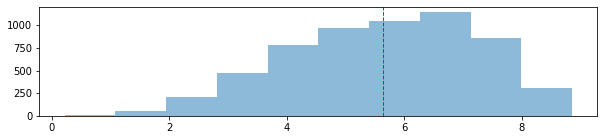

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

ax.hist(order_interval_tmp['cst_order_interval'], alpha=0.5)
ax.axvline(order_interval_tmp['cst_order_interval'].mean(), color = 'r', linestyle='dashed', linewidth=1)

In [83]:
cst_feature_info = cst_feature_info.merge(order_interval_tmp, on = 'cstno')
cst_feature_info.head()

,cstno,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval
0,10000,11.710890,8,72,36,13.257576,0.659091,4.707692
1,100001,13.343696,10,66,23,9.952381,0.775000,5.467742
2,100046,14.943764,16,65,28,10.580645,0.727273,4.704918
3,100071,13.519928,16,53,23,9.764706,0.888889,5.560000
4,100108,11.967736,12,70,17,5.682540,0.772727,5.238095


In [84]:
del(order_interval_tmp)

## 2.3. 상품별 주문현황 (상품 특성 테이블 생성)

기존에 봤던 division, category 삭제

### 2.3.1. product_name 기준

    - 상품이 총 구매된 횟수 (count)
    - 상품이 재구매된 횟수 (sum)

In [85]:
prod_tmp = train_new_past.groupby('name')['is_reordered_int'].agg(['count','sum'])
prod_tmp = prod_tmp.sort_values('count', ascending = False).reset_index()

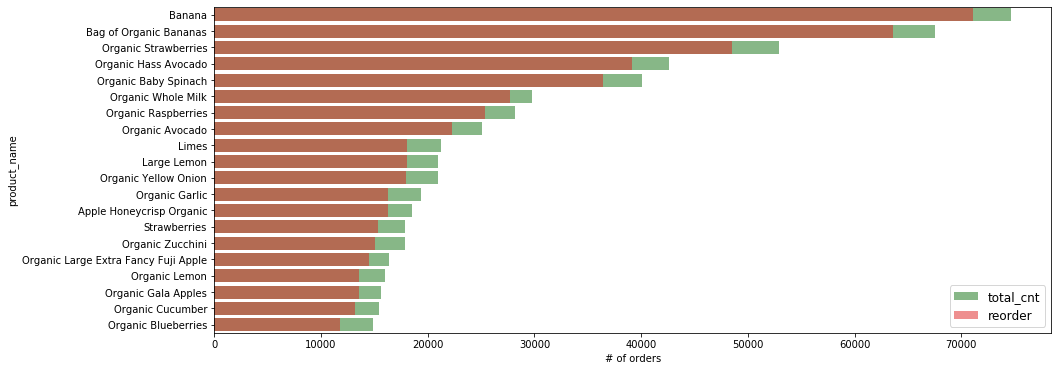

In [86]:
fig, ax = plt.subplots(figsize = (15,6))

ax = sns.barplot(y = prod_tmp['name'][0:20],x = prod_tmp['count'][0:20], color = 'green',alpha = 0.5, label = 'total_cnt')
ax = sns.barplot(y = prod_tmp['name'][0:20],x = prod_tmp['sum'][0:20], color = 'red', alpha = 0.5, label = 'reorder')
ax.set_ylabel('product_name')
ax.set_xlabel('# of orders')
ax.legend(loc = 4, prop = {'size':12})

plt.show()

구매횟수가 많았던 20개 상품에 대한 구매/재구매 횟수 그래프 <br>
-> 그래프 상으로는 구매가 많은 상품은 재구매도 많아보임. 실제로 구매가 많은 상품들이 재구매율이 높을까?

    - 상품별 총 구매된 횟수 중에 재구매된 횟수의 비율 (reorder_ratio)

In [87]:
prod_tmp['reorder_ratio'] = prod_tmp['sum'] / prod_tmp['count']
prod_tmp = prod_tmp.sort_values('reorder_ratio', ascending=False).reset_index(drop = True)

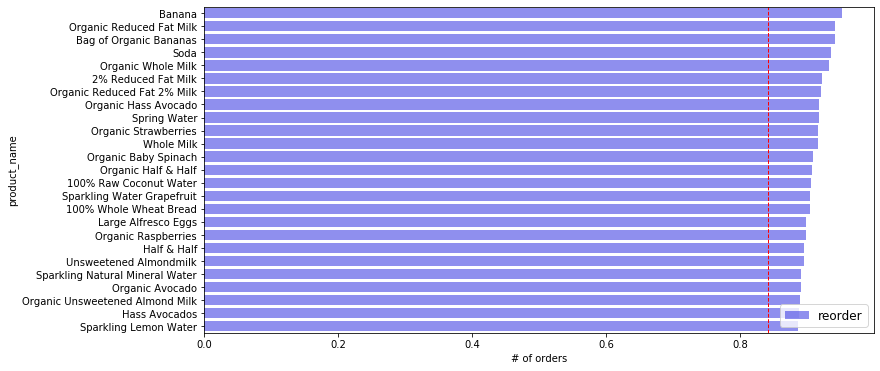

In [88]:
fig, ax = plt.subplots(figsize = (12,6))

ax = sns.barplot(y = prod_tmp['name'][0:25],x = prod_tmp['reorder_ratio'][0:25], color = 'blue', alpha = 0.5, label = 'reorder')
ax.set_ylabel('product_name')
ax.set_xlabel('# of orders')
ax.legend(loc = 4, prop = {'size':12})

ax.axvline(prod_tmp['reorder_ratio'].mean() , color = 'r', linestyle = 'dashed', linewidth = 1)

plt.show()

재구매율이 높았던 20개 상품에 대한 재구매율 그래프 <br>
-> 건수 기반 rank와 재구매율 기반 rank를 봤을 때 차이가 있는 것으로 보임

In [89]:
#건수기반
top_number_prod = prod_tmp.sort_values('count', ascending = False)
top_number_prod.reset_index(drop = True, inplace = True)
top_number_prod['rank'] = top_number_prod.index+1
top_number_prod.head()

,name,count,sum,reorder_ratio,rank
0,Banana,74686,71104,0.952039,1
1,Bag of Organic Bananas,67514,63601,0.942042,2
2,Organic Strawberries,52917,48516,0.916832,3
3,Organic Hass Avocado,42604,39136,0.918599,4
4,Organic Baby Spinach,40112,36444,0.908556,5


In [90]:
#재구매율기반
top_ratio_prod = prod_tmp.sort_values('reorder_ratio', ascending = False)
top_ratio_prod.reset_index(drop = True, inplace = True)
top_ratio_prod['rank'] = top_ratio_prod.index+1
top_ratio_prod.head()

,name,count,sum,reorder_ratio,rank
0,Banana,74686,71104,0.952039,1
1,Organic Reduced Fat Milk,8837,8327,0.942288,2
2,Bag of Organic Bananas,67514,63601,0.942042,3
3,Soda,2712,2539,0.936209,4
4,Organic Whole Milk,29757,27753,0.932655,5


In [91]:
order_prod_rank = top_number_prod.merge(top_ratio_prod[['name','rank']], on='name')
order_prod_rank['rank_diff'] = order_prod_rank['rank_x'] - order_prod_rank['rank_y']
order_prod_rank['rank_diff'] = order_prod_rank['rank_diff'].abs()
order_prod_rank.rename(columns = {'rank_x':'by_cnt_rank', 'rank_y':'by_re_ratio_rank'}, inplace = True)

In [92]:
order_prod_rank.loc[order_prod_rank['by_cnt_rank'] <= 20].sort_values(['rank_diff','by_re_ratio_rank']).head()

,name,count,sum,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff
0,Banana,74686,71104,0.952039,1,1,0
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1
5,Organic Whole Milk,29757,27753,0.932655,6,5,1
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4
2,Organic Strawberries,52917,48516,0.916832,3,10,7


-> 상품별로 구매가 많다고 재구매율이 높은 것은 아님 확인

In [93]:
#category_name붙이기

order_prod_rank = order_prod_rank.merge(products_info[['name','division_name','category_name','product_id']], on = 'name')

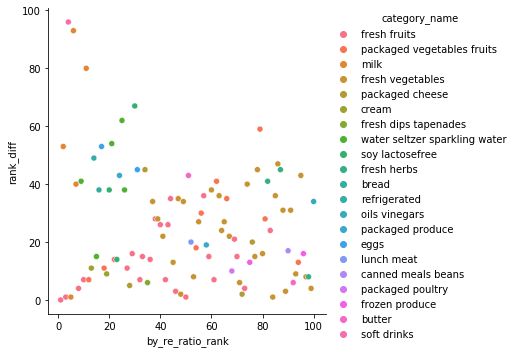

In [94]:
sns.relplot(x = 'by_re_ratio_rank',y ='rank_diff',hue = 'category_name', data = order_prod_rank)

    - 상품을 주문한 고객의 비율 (cst_ratio)
    - 상품을 주문한 고객의 비율 순위 (cst_rank)

In [95]:
#order_prod_rank 에 각 상품을 구매한 고객 수, 고객비중 추가

total_cst_cnt = train_new_past['cstno'].nunique()
prod_cst_cnt = train_new_past.groupby('name')['cstno'].nunique()
prod_cst_cnt = pd.DataFrame(prod_cst_cnt)
prod_cst_cnt.reset_index(inplace = True)
prod_cst_cnt['cst_ratio'] = prod_cst_cnt['cstno'] / total_cst_cnt
prod_cst_cnt.rename(columns = {'cstno':'cst_cnt'})

prod_cst_cnt = prod_cst_cnt.sort_values('cst_ratio', ascending = False).reset_index(drop = True)
prod_cst_cnt['cst_rank'] = prod_cst_cnt.index+1

In [96]:
prod_cst_cnt.head()

,name,cstno,cst_ratio,cst_rank
0,Organic Strawberries,4401,0.751152,1
1,Bag of Organic Bananas,3913,0.667861,2
2,Organic Baby Spinach,3668,0.626045,3
3,Banana,3582,0.611367,4
4,Organic Hass Avocado,3468,0.591910,5


In [97]:
prod_cst_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       100 non-null    object 
 1   cstno      100 non-null    int64  
 2   cst_ratio  100 non-null    float64
 3   cst_rank   100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [98]:
#order_prod_rank와 결합
prod_feature_info = order_prod_rank.merge(prod_cst_cnt[['name','cst_ratio','cst_rank']], on = 'name')
prod_feature_info.head(10)

,name,count,sum,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank
0,Banana,74686,71104,0.952039,1,1,0,produce,fresh fruits,24852,0.611367,4
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1,produce,fresh fruits,13176,0.667861,2
2,Organic Strawberries,52917,48516,0.916832,3,10,7,produce,fresh fruits,21137,0.751152,1
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4,produce,fresh fruits,47209,0.591910,5
4,Organic Baby Spinach,40112,36444,0.908556,5,12,7,produce,packaged vegetables fruits,21903,0.626045,3
5,Organic Whole Milk,29757,27753,0.932655,6,5,1,dairy eggs,milk,27845,0.342038,32
6,Organic Raspberries,28207,25332,0.898075,7,18,11,produce,packaged vegetables fruits,27966,0.490698,11
7,Organic Avocado,25046,22303,0.890482,8,22,14,produce,fresh fruits,47766,0.468169,13
8,Limes,21216,18018,0.849265,9,44,35,produce,fresh fruits,26209,0.545827,6
9,Large Lemon,21012,18069,0.859937,10,38,28,produce,fresh fruits,47626,0.502304,10


In [99]:
#컬럼명 변경
prod_feature_info.rename(columns = {'count':'order_cnt', 'sum':'reorder_cnt'}, inplace = True)

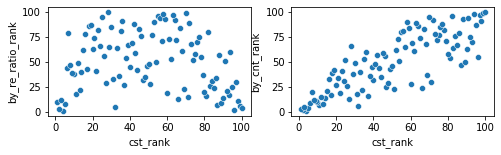

In [100]:
fig, ax = plt.subplots(1,2, figsize = (8,2))
ax = ax.ravel()

sns.scatterplot(ax = ax[0], y = 'by_re_ratio_rank',x ='cst_rank', data = prod_feature_info)
sns.scatterplot(ax = ax[1], y = 'by_cnt_rank',x ='cst_rank', data = prod_feature_info)

plt.show()

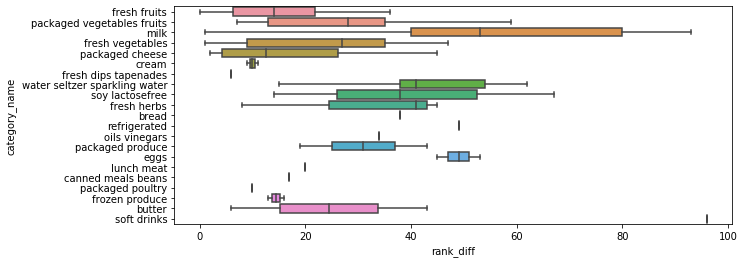

In [101]:
plt.figure(figsize = (10,4))
sns.boxplot(x = 'rank_diff',y ='category_name', data = prod_feature_info.sort_values('by_cnt_rank'), orient = 'h')
plt.show()

In [102]:
prod_feature_info.loc[prod_feature_info['category_name']=='milk']

,name,order_cnt,reorder_cnt,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank
5,Organic Whole Milk,29757,27753,0.932655,6,5,1,dairy eggs,milk,27845,0.342038,32
46,Organic Reduced Fat 2% Milk,10114,9318,0.921297,47,7,40,dairy eggs,milk,5785,0.135859,87
54,Organic Reduced Fat Milk,8837,8327,0.942288,55,2,53,dairy eggs,milk,38689,0.087046,96
90,Whole Milk,5149,4717,0.916100,91,11,80,dairy eggs,milk,4210,0.073733,98
98,2% Reduced Fat Milk,3547,3273,0.922752,99,6,93,dairy eggs,milk,23909,0.046766,99


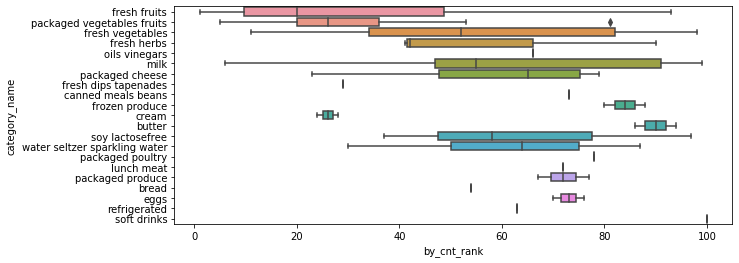

In [103]:
plt.figure(figsize = (10,4))
sns.boxplot(x = 'by_cnt_rank',y ='category_name', data = prod_feature_info.sort_values('cst_rank'), orient = 'h')
plt.show()

- 고객수rank 상위 category에서 동일 category 내 상품별로 편차가 큰 것으로 보여짐 (상품이 많고 , 많은 고객이 샀으니 당연한 결과일 수 있음)
- 한 category 안에 상품종류가 많은 fresh_fruits, fresh_vegetables는 예외

In [104]:
#가장 많은 고객이 구매한 top20상품
prod_feature_info.sort_values('cst_rank').head(20)

,name,order_cnt,reorder_cnt,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank
2,Organic Strawberries,52917,48516,0.916832,3,10,7,produce,fresh fruits,21137,0.751152,1
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1,produce,fresh fruits,13176,0.667861,2
4,Organic Baby Spinach,40112,36444,0.908556,5,12,7,produce,packaged vegetables fruits,21903,0.626045,3
0,Banana,74686,71104,0.952039,1,1,0,produce,fresh fruits,24852,0.611367,4
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4,produce,fresh fruits,47209,0.591910,5
8,Limes,21216,18018,0.849265,9,44,35,produce,fresh fruits,26209,0.545827,6
19,Organic Blueberries,14859,11806,0.794535,20,79,59,produce,packaged vegetables fruits,39275,0.521079,7
11,Organic Garlic,19332,16280,0.842127,12,47,35,produce,fresh vegetables,24964,0.520908,8
10,Organic Yellow Onion,20977,17995,0.857844,11,39,28,produce,fresh vegetables,22935,0.508961,9
9,Large Lemon,21012,18069,0.859937,10,38,28,produce,fresh fruits,47626,0.502304,10


In [105]:
top5_cat = ['fresh vegetables','fresh fruits','packaged vegetables fruits','milk','water seltzer sparkling water']
prod_name_tmp = products_info.loc[products_info['category_name'].isin(top5_cat)]['name']
prod_name_tmp = pd.DataFrame(prod_name_tmp)
prod_name_tmp.reset_index(drop = True, inplace = True)
prod_name_tmp[prod_name_tmp['name'].str.contains('Organic')].count() / prod_name_tmp.shape[0]

name    0.555556
dtype: float64

유기농 제품의 비율 55.6%

In [106]:
#Organic이 많이 보임 -> 유기농상품의 구매비중은?
prod_feature_info.loc[prod_feature_info['name'].str.contains('Organic')]['cst_ratio'].sum()

17.158559481140124

59.1%의 고객이 유기농제품에 관심이 있음

    - 유기농 상품 여부 (organic_yn)

In [107]:
# 유기농상품여부 추가
organic_yn = prod_feature_info['name'].str.contains('Organic').astype('int')
prod_feature_info['organic_yn'] = organic_yn

prod_feature_info.head(10)

,name,order_cnt,reorder_cnt,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank,organic_yn
0,Banana,74686,71104,0.952039,1,1,0,produce,fresh fruits,24852,0.611367,4,0
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1,produce,fresh fruits,13176,0.667861,2,1
2,Organic Strawberries,52917,48516,0.916832,3,10,7,produce,fresh fruits,21137,0.751152,1,1
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4,produce,fresh fruits,47209,0.591910,5,1
4,Organic Baby Spinach,40112,36444,0.908556,5,12,7,produce,packaged vegetables fruits,21903,0.626045,3,1
5,Organic Whole Milk,29757,27753,0.932655,6,5,1,dairy eggs,milk,27845,0.342038,32,1
6,Organic Raspberries,28207,25332,0.898075,7,18,11,produce,packaged vegetables fruits,27966,0.490698,11,1
7,Organic Avocado,25046,22303,0.890482,8,22,14,produce,fresh fruits,47766,0.468169,13,1
8,Limes,21216,18018,0.849265,9,44,35,produce,fresh fruits,26209,0.545827,6,0
9,Large Lemon,21012,18069,0.859937,10,38,28,produce,fresh fruits,47626,0.502304,10,0


## 2.4. 고객특성 테이블 + 상품특성 테이블 연결

In [108]:
prod_per_cst = train_new_past[['cstno','product_id']].value_counts()
prod_per_cst = pd.DataFrame(prod_per_cst)
prod_per_cst.reset_index(inplace = True)

In [109]:
prod_per_cst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170198 entries, 0 to 170197
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   cstno       170198 non-null  object
 1   product_id  170198 non-null  object
 2   0           170198 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [110]:
feature_info = prod_per_cst[['cstno','product_id']].merge(cst_feature_info, on = 'cstno')
feature_info = feature_info.merge(prod_feature_info[['division_name','category_name','product_id','name','reorder_ratio', 'by_cnt_rank','by_re_ratio_rank','rank_diff','cst_ratio','cst_rank','organic_yn']], on = 'product_id')
feature_info.head()

,cstno,product_id,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval,division_name,category_name,name,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,cst_ratio,cst_rank,organic_yn
0,103593,28204,11.272227,10,99,29,13.434343,1.000000,3.704082,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
1,99707,28204,12.394383,13,99,22,8.151515,0.800000,1.520408,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
2,54804,28204,11.386740,9,99,23,9.918367,0.857143,3.371134,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
3,32971,28204,12.432598,14,99,13,6.484536,1.000000,2.645833,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
4,166908,28204,14.841954,14,99,10,2.367816,0.500000,2.290698,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1


In [111]:
feature_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170198 entries, 0 to 170197
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cstno                    170198 non-null  object 
 1   product_id               170198 non-null  object 
 2   mean_order_hour          170198 non-null  float64
 3   mode_cst_hour            170198 non-null  int64  
 4   cst_orders_cnt           170198 non-null  int64  
 5   totl_prod_cnt_per_order  170198 non-null  int64  
 6   mean_prod_cnt_per_order  170198 non-null  float64
 7   cst_reorder_ratio        170198 non-null  float64
 8   cst_order_interval       170198 non-null  float64
 9   division_name            170198 non-null  object 
 10  category_name            170198 non-null  object 
 11  name                     170198 non-null  object 
 12  reorder_ratio            170198 non-null  float64
 13  by_cnt_rank              170198 non-null  int64  
 14  by_r

In [112]:
feature_info.rename(columns = {'reorder_ratio':'prod_reorder_ratio', 'cst_ratio':'prod_cst_ratio','cst_rank':'prod_cst_rank'}, inplace = True)

In [113]:
feature_info.head(3)

,cstno,product_id,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval,division_name,category_name,name,prod_reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,prod_cst_ratio,prod_cst_rank,organic_yn
0,103593,28204,11.272227,10,99,29,13.434343,1.000000,3.704082,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
1,99707,28204,12.394383,13,99,22,8.151515,0.800000,1.520408,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
2,54804,28204,11.386740,9,99,23,9.918367,0.857143,3.371134,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1


## 2.5. 고객+상품 특성

현재 분석 목적은 특정 고객이 어떤 상품을 재구매 했을 것인지 예측하는 것이므로, <br>
고객+상품별 재구매 관련 지표를 먼저 생성

### 2.5.1. 고객+상품별 재구매횟수

    - 고객+상품별 재구매 횟수 (cst_prod_reorder_cnt)

In [114]:
reorder_cnt = train_new_past.groupby(['cstno','product_id'])['is_reordered_int'].sum()
reorder_cnt = pd.DataFrame(reorder_cnt)
reorder_cnt.reset_index(inplace = True)

In [115]:
reorder_cnt.rename(columns = {'is_reordered_int':'cst_prod_reorder_cnt'}, inplace = True)
feature_info = feature_info.merge(reorder_cnt, on = ['cstno','product_id'], how = 'left')

type_change(feature_info, 'cst_prod_reorder_cnt', 'int')

### 2.5.2. 고객이 특정상품을 제품을 재구매할 확률

    - 고객의 재구매 횟수 중 특정 상품을 재구매 할 확률 (prod_cst_reorder_ratio)
       : 고객 상품별 재구매 횟수 / 고객별 재구매 횟수

In [116]:
# 특정 상품에 대한 구매확률을 누락시켜버릴 수 있는 문제 때문에 1을 더해서 산출 (laplace smoothing)

prod_cst_reorder_ratio = train_new_past.groupby(['cstno','product_id'])['is_reordered_int'].sum() + 1

In [117]:
prod_cst_reorder_ratio = prod_cst_reorder_ratio /  prod_cst_reorder_ratio.groupby('cstno').sum()

In [118]:
prod_cst_reorder_ratio = pd.DataFrame(prod_cst_reorder_ratio)
prod_cst_reorder_ratio.reset_index(inplace = True)
prod_cst_reorder_ratio.rename(columns = {'is_reordered_int': 'prod_cst_reorder_ratio'}, inplace = True)

In [119]:
feature_info = feature_info.merge(prod_cst_reorder_ratio, on = ['cstno','product_id'], how = 'left')

### 2.5.3. 상품별 장바구니 순서

In [120]:
all_add_max = train_new_past.groupby('product_id')[['add_order','new_add_order']].max()+1

prod_add_rn = train_new_past.groupby('product_id')[['add_order','new_add_order']].mean()
prod_add_prob = 1-prod_add_rn / all_add_max

prod_add_rn.reset_index(inplace = True)
prod_add_prob.reset_index(inplace = True)

prod_add_rn.rename(columns={'add_order':'prod_first_add_rn_1','new_add_order':'prod_first_add_rn_2'}, inplace = True)
prod_add_prob.rename(columns={'add_order':'prod_first_add_prob_1', 'new_add_order':'prod_first_add_prob_2'}, inplace = True)

feature_info = feature_info.merge(prod_add_rn, on = ['product_id'], how = 'left')
feature_info = feature_info.merge(prod_add_prob, on = ['product_id'], how = 'left')

### 2.5.4. 고객이 특정상품을 장바구니에 먼저 담을 확률

In [121]:
cst_add_max = train_new_past.groupby('cstno')[['add_order','new_add_order']].max()+1
add_rn = train_new_past.groupby(['cstno','product_id'])[['add_order','new_add_order']].mean()

cst_add_max.reset_index(inplace = True)
add_rn.reset_index(inplace = True)

add_rn = add_rn.merge(cst_add_max, on = 'cstno', how = 'left')

add_rn['prod_cst_first_add_prob_1'] = 1-add_rn['add_order_x'] / add_rn['add_order_y']
add_rn['prod_cst_first_add_prob_2'] = 1-add_rn['new_add_order_x'] / add_rn['new_add_order_y']

add_rn.rename(columns = {'add_order_x':'prod_cst_first_add_rn_1','new_add_order_x':'prod_cst_first_add_rn_2'}, inplace = True)
add_rn.drop(['add_order_y','new_add_order_y'], axis = 1, inplace = True)

In [122]:
feature_info = feature_info.merge(add_rn, on = ['cstno','product_id'], how = 'left')

In [123]:
del(all_add_max, prod_add_rn, prod_add_prob, cst_add_max, add_rn)

### 2.5.5. 주문번호, 주문간격

10.19 기준 재구매율, organic 반영한 기준으로 random forest 모형 f1 score 0.18<br>
재구매율은 변수 중요도가 0.35로 높았기때문에 유지, organic 변수 제거<br>
예측율을 높이기위해 기존변수 중 활용하지 않은 변수가 있는지 다시 확인

In [124]:
train_new_past.head(3)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,new_add_order,new_order_number,cst_rn,name,category_id,division_id,category_name,division_name,is_reordered_int
0,717029,196613,15,1,9,3,5,0,41220,0,1,12,34,Organic Romaine Lettuce,83,4,fresh vegetables,produce,0
1,2325772,196613,35,6,11,2,7,1,41220,0,2,26,86,Organic Romaine Lettuce,83,4,fresh vegetables,produce,1
2,642668,196613,69,2,16,2,11,1,4210,0,3,53,163,Whole Milk,84,16,milk,dairy eggs,1


시간대는 의미가 없었고, order_interval, order_number를 활용해봐야할 것 같음<br>
다만 이 컬럼들은 고객별로 전부 달라 절대적인 값으로는 고객간 비교가 어렵기때문에 고객별 특성을 봐보려고함<br>

order number min/max

In [125]:
cp_order_min = train_new_past.groupby(['cstno','product_id'])['new_order_number'].min()
cp_order_max = train_new_past.groupby(['cstno','product_id'])['new_order_number'].max()

In [126]:
#고객별 order_number min값은 전부 1일테니까 (모두 최소 1번씩은 구매했기때문에 -- max만 산출
c_order_max = cp_order_max.groupby('cstno').max()

In [127]:
cp_order_min = pd.DataFrame(cp_order_min)
cp_order_max = pd.DataFrame(cp_order_max)
c_order_max = pd.DataFrame(c_order_max)

cp_order_min.reset_index(inplace = True)
cp_order_max.reset_index(inplace = True)
c_order_max.reset_index(inplace = True)

cp_order_min.rename(columns = {'new_order_number':'cp_order_num_min'}, inplace = True)
cp_order_max.rename(columns = {'new_order_number':'cp_order_num_max'}, inplace = True)
c_order_max.rename(columns = {'new_order_number':'c_order_num_max'}, inplace = True)

In [128]:
feature_info = feature_info.merge(cp_order_min, on = ['cstno','product_id'], how ='left')
feature_info = feature_info.merge(cp_order_max, on = ['cstno','product_id'], how ='left')
feature_info = feature_info.merge(c_order_max, on = 'cstno', how ='left')

고객+상품별 주문번호 간격추가

interval은,, 누적값으로 잡아야됨 다시,,

In [129]:
# feature_info.drop(['cp_order_interval_min', 'cp_order_interval_max_x','cp_order_interval_max_y'], axis = 1, inplace= True)

In [130]:
# 고객+상품별 order_interval 누적
# 고객+주문별 한 건씩만 추출하기 위해 add_order == 1 조건 추가

recent_tmp = train_new_past.loc[(train_new_past['new_add_order'] == 1)].sort_values(['cstno','new_order_number'])[['cstno','order_id','new_order_number','order_interval']]

# interval -1인 고객별 첫주문건 반영위해 +1
recent_tmp['cum_interval'] = recent_tmp.groupby('cstno')['order_interval'].cumsum()+1
recent_tmp.head(3)

,cstno,order_id,new_order_number,order_interval,cum_interval
423552,10000,1492646,1,-1,0
423288,10000,1444722,2,6,6
423412,10000,3272690,3,2,8


cstno, order_id, product_id pk 인 테이블 생성

In [131]:
recent_tmp = recent_tmp.merge(train_new_past[['order_id','product_id']], on = 'order_id', how = 'left')

cum_max = recent_tmp.groupby (['cstno','product_id'])['cum_interval'].max()
cum_min = recent_tmp.groupby (['cstno','product_id'])['cum_interval'].min()
cst_max = recent_tmp.groupby ('cstno')['cum_interval'].max()

cum_max = pd.DataFrame(cum_max)
cum_min = pd.DataFrame(cum_min)
cst_max = pd.DataFrame(cst_max)

cum_max.reset_index(inplace = True)
cum_min.reset_index(inplace = True)
cst_max.reset_index(inplace = True)

In [132]:
cum_tmp = pd.merge(left = cum_max, right = cum_min, on = ['cstno','product_id'], how = 'left')
cum_tmp = cum_tmp.merge(cst_max, on = 'cstno', how = 'left')
cum_tmp.rename(columns = {'cum_interval_x':'cst_prod_cum_interval_max', 'cum_interval_y' : 'cst_prod_cum_interval_min', 'cum_interval':'cst_cum_interval'}, inplace = True)

cum_tmp.head()

,cstno,product_id,cst_prod_cum_interval_max,cst_prod_cum_interval_min,cst_cum_interval
0,10000,10749,302,36,306
1,10000,11520,306,166,306
2,10000,13176,249,36,306
3,10000,15290,255,0,306
4,10000,16759,166,166,306


In [133]:
# 구매기간
cum_tmp['order_period'] = cum_tmp['cst_prod_cum_interval_max'] - cum_tmp['cst_prod_cum_interval_min']


#cum_tmp를 feature_info에 조인
feature_info = feature_info.merge(cum_tmp, on = ['cstno','product_id'], how = 'left')

### 2.5.6. 직전 주문과의 연관성

order_number, new_order_number 둘 다 확인

In [134]:
prior_diff_1 = train_new_past[['cstno','product_id','order_number']].value_counts()
prior_diff_1 = pd.DataFrame(prior_diff_1)
prior_diff_1.reset_index(inplace = True)

prior_diff_1.drop(0, axis = 1, inplace = True)

prior_diff_1 = prior_diff_1.sort_values(['cstno','product_id','order_number'])
prior_diff_1.reset_index(inplace = True, drop = True)

prior_diff_1['order_diff_mean'] = prior_diff_1['order_number'].diff()

#첫주문 결측치
prior_diff_1['order_diff_mean'].fillna(0, inplace = True)
#이전 행 상품 != 현재 행 상품인 경우
prior_diff_1.loc[prior_diff_1['order_diff_mean'] < 0, 'order_diff_mean'] = 0

prior_diff_1 = prior_diff_1.groupby(['cstno','product_id'])['order_diff_mean'].mean()
prior_diff_1 = pd.DataFrame(prior_diff_1)
prior_diff_1.reset_index(inplace = True)

In [135]:
prior_diff_2 = train_new_past[['cstno','product_id','new_order_number']].value_counts()
prior_diff_2 = pd.DataFrame(prior_diff_2)
prior_diff_2.reset_index(inplace = True)

prior_diff_2.drop(0, axis = 1, inplace = True)

prior_diff_2 = prior_diff_2.sort_values(['cstno','product_id','new_order_number'])
prior_diff_2.reset_index(inplace = True, drop = True)

prior_diff_2['new_order_diff_mean'] = prior_diff_2['new_order_number'].diff()

#첫주문 결측치
prior_diff_2['new_order_diff_mean'].fillna(0, inplace = True)
#이전 행 상품 != 현재 행 상품인 경우
prior_diff_2.loc[prior_diff_2['new_order_diff_mean'] < 0, 'new_order_diff_mean'] = 0

prior_diff_2 = prior_diff_2.groupby(['cstno','product_id'])['new_order_diff_mean'].mean()
prior_diff_2 = pd.DataFrame(prior_diff_2)
prior_diff_2.reset_index(inplace = True)

In [136]:
feature_info = feature_info.merge(prior_diff_1, on = ['cstno','product_id'], how = 'left')
feature_info = feature_info.merge(prior_diff_2, on = ['cstno','product_id'], how = 'left')

### 2.5.7. 마지막(현재)에 주문한 상품과의 연관성

In [137]:
feature_info = feature_info.merge(train_new_current.loc[train_new_current['is_reordered'] == '1'][['cstno','product_id','is_reordered']], on = ['cstno','product_id'], how = 'left')

In [138]:
#가장 마지막에 주문하지 않았던 상품들의 재주문 여부를 0으로 설정
feature_info['is_reordered'].fillna('0',inplace = True)
#컬럼명 수정
feature_info.rename(columns = {'is_reordered':'final_reorder_yn'}, inplace = True)

In [139]:
feature_info.loc[feature_info['final_reorder_yn'] == '1'].describe()

,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval,prod_reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,prod_cst_ratio,prod_cst_rank,organic_yn,cst_prod_reorder_cnt,...,prod_first_add_prob_1,prod_first_add_prob_2,prod_cst_first_add_rn_1,prod_cst_first_add_rn_2,prod_cst_first_add_prob_1,prod_cst_first_add_prob_2,cp_order_num_min,cp_order_num_max,c_order_num_max,cst_prod_cum_interval_max,cst_prod_cum_interval_min,cst_cum_interval,order_period,order_diff_mean,new_order_diff_mean
count,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.00000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,...,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000
mean,13.210811,12.748858,63.084439,26.958194,11.284945,0.758190,5.843791,0.864464,31.52186,38.917823,20.055379,0.396367,33.329534,0.619307,16.541697,...,0.887190,0.843388,8.069325,3.356021,0.705825,0.695881,14.500326,54.407187,58.186801,295.440901,79.130639,315.742942,216.310262,4.502410,4.110288
std,1.649560,3.912697,17.023905,10.751277,5.258399,0.099996,1.573777,0.055137,27.58599,28.953181,17.043039,0.178840,28.808457,0.485568,14.794119,...,0.029448,0.026897,4.779153,1.729719,0.133303,0.119933,17.633177,16.355975,14.724312,65.839849,98.967985,49.213116,114.951279,5.854692,5.139320
min,3.387046,0.000000,42.000000,1.000000,1.000000,0.250000,0.220930,0.710194,1.00000,1.000000,0.000000,0.029527,1.000000,0.000000,0.000000,...,0.803426,0.783264,1.000000,1.000000,0.020000,0.050000,1.000000,1.000000,42.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000
25%,12.117799,10.000000,50.000000,20.000000,7.545455,0.694444,4.705882,0.822308,7.00000,12.000000,7.000000,0.258577,7.000000,0.000000,5.000000,...,0.867588,0.820961,4.769231,2.111111,0.636364,0.634615,1.000000,44.000000,47.000000,268.000000,1.000000,299.000000,117.000000,1.686887,1.592593
50%,13.172149,12.000000,58.000000,26.000000,10.257732,0.764706,6.019608,0.861653,24.00000,37.000000,15.000000,0.380099,26.000000,1.000000,12.000000,...,0.886094,0.842336,7.000000,3.000000,0.725806,0.714286,5.000000,51.000000,53.000000,318.000000,28.000000,334.000000,249.000000,2.750000,2.550000
75%,14.281921,15.000000,73.000000,33.000000,13.968254,0.823529,7.090909,0.908556,51.00000,62.000000,34.000000,0.521079,54.000000,1.000000,25.000000,...,0.908669,0.865064,10.200000,4.149468,0.798813,0.777778,24.000000,63.000000,66.000000,343.000000,140.000000,350.000000,319.000000,5.000000,4.583333
max,22.398353,23.000000,99.000000,115.000000,46.047619,1.000000,8.853659,0.952039,100.00000,100.000000,96.000000,0.751152,100.000000,1.000000,97.000000,...,0.936153,0.888690,65.000000,19.000000,0.982143,0.947368,98.000000,99.000000,99.000000,364.000000,362.000000,364.000000,364.000000,95.000000,89.000000


In [140]:
feature_info.loc[feature_info['final_reorder_yn'] == '0'].describe()

,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval,prod_reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,prod_cst_ratio,prod_cst_rank,organic_yn,cst_prod_reorder_cnt,...,prod_first_add_prob_1,prod_first_add_prob_2,prod_cst_first_add_rn_1,prod_cst_first_add_rn_2,prod_cst_first_add_prob_1,prod_cst_first_add_prob_2,cp_order_num_min,cp_order_num_max,c_order_num_max,cst_prod_cum_interval_max,cst_prod_cum_interval_min,cst_cum_interval,order_period,order_diff_mean,new_order_diff_mean
count,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,...,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000,147211.000000
mean,13.282370,12.864338,66.083880,26.070131,10.367194,0.736565,5.588930,0.837661,39.966191,52.548451,22.698908,0.356502,37.250898,0.586206,4.779059,...,0.876520,0.834351,9.039077,3.620320,0.660903,0.662865,19.686172,41.686559,59.895877,215.436802,103.157142,310.071707,112.279660,6.478179,5.829277
std,1.603668,3.851039,17.828246,10.128443,4.645978,0.099114,1.588276,0.053110,27.625151,28.317805,16.044661,0.146402,26.131367,0.492514,7.310435,...,0.028576,0.023393,5.912164,2.081406,0.176998,0.158393,18.903488,21.344758,15.249790,99.832762,98.838424,51.108225,113.286351,8.638910,7.615118
min,3.387046,0.000000,42.000000,1.000000,1.000000,0.250000,0.220930,0.710194,1.000000,1.000000,0.000000,0.029527,1.000000,0.000000,0.000000,...,0.803426,0.783264,1.000000,1.000000,0.013889,0.047619,1.000000,1.000000,42.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000
25%,12.237729,10.000000,51.000000,19.000000,7.068182,0.674419,4.421875,0.795377,15.000000,30.000000,8.000000,0.240485,15.000000,0.000000,0.000000,...,0.856732,0.817143,5.000000,2.000000,0.565217,0.575758,4.000000,27.000000,48.000000,142.000000,15.000000,290.000000,0.000000,1.230769,1.100000
50%,13.258136,13.000000,61.000000,25.000000,9.451613,0.743590,5.658537,0.835415,36.000000,52.000000,21.000000,0.336406,33.000000,1.000000,2.000000,...,0.877693,0.836026,7.800000,3.000000,0.685990,0.687500,13.000000,42.000000,55.000000,236.000000,70.000000,328.000000,78.000000,4.000000,3.600000
75%,14.308296,15.000000,79.000000,31.000000,12.627907,0.804878,6.862745,0.878457,61.000000,78.000000,35.000000,0.438300,57.000000,1.000000,6.000000,...,0.895818,0.850540,11.666667,4.625000,0.784280,0.776786,32.000000,54.000000,69.000000,300.000000,178.000000,347.000000,208.000000,8.250000,7.500000
max,22.398353,23.000000,99.000000,115.000000,46.047619,1.000000,8.853659,0.952039,100.000000,100.000000,96.000000,0.751152,100.000000,1.000000,91.000000,...,0.936153,0.888690,71.000000,20.500000,0.986842,0.961538,99.000000,99.000000,99.000000,364.000000,364.000000,364.000000,364.000000,97.000000,92.000000


reorder, order_interval에서 유의미한 차이를 보이는 것으로 보임
- 구매 기간이 길고, 비교적 마지막까지 구매했던 상품을 재구매함
- 생성해놓은 누적 일수 변수를 사용해서 '최근 구매'에 대한 변수 생성

### 2.5.8. 최근 구매 상품

- 최근 구매가 아닌 '가장 마지막' 주문 상품을 재구매 하지 않은 비중이 훨씬 높음 -> 100%라는 확률에 구매하지 않을 확률을 반영해야함
- 과거의 마지막에 구매했기 때문에 최종주문때는 하지 않은 것을 추정됨

     - 과거의 마지막시점에서의 누적대비 비중이 아닌 현재기준 대비 마지막 구매시점이 필요함
     - 과거의 마지막시점에서 다음 예상구매시점(+상품별 평균구매기간)과 현재시점과의 비교도 필요할 것으로 생각됨

In [141]:
# cst_prod_reorder_cnt는 재구매횟수 카운트값이기 때문에 총 구매횟수는 +1
#같은 날 다른 시간에 구매한 경우 order interval이 0이기 때문에 분자에도 +1

feature_info['mean_order_interval'] = (feature_info['order_period']+1) / (feature_info['cst_prod_reorder_cnt']+1)

In [142]:
# 현재시점 추출 - train_new_current data 사용

feature_info = feature_info.merge(train_new_current.loc[train_new_current['new_add_order'] == 1][['cstno','order_interval']], on = ['cstno'], how = 'left')
feature_info.rename(columns = {'order_interval':'last_interval'}, inplace = True)

In [143]:
#1. 현재시점 대비 마지막 구매시점 비중 (높을 수록 최근 구매)
feature_info['last_order_prob_1'] = feature_info['cst_prod_cum_interval_max'] / (feature_info['cst_cum_interval'] + feature_info['last_interval'])

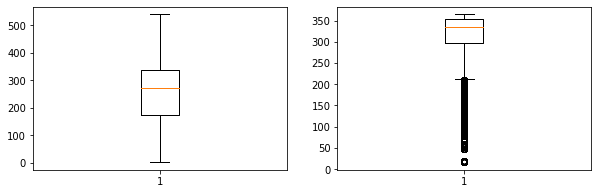

In [144]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
ax = ax.ravel()

ax[0].boxplot((feature_info['cst_prod_cum_interval_max'] + feature_info['mean_order_interval'])) # 다음 예상 구매시점
ax[1].boxplot((feature_info['cst_cum_interval'] + feature_info['last_interval']))   # 현재시점

plt.show()

In [145]:
#2. 다음 구매예상 시점과 현재시점과의 비교
feature_info['last_order_prob_2'] = (feature_info['cst_cum_interval'] + feature_info['last_interval']) / (feature_info['cst_prod_cum_interval_max'] + feature_info['mean_order_interval'])

---

# 3. 모델링

> RandomForest, ExtraTrees, GBC, XGBoost 중 가장 성능이 좋았던 **RandomForest** 사용

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

## 3.1. 모델링 전 변수 선택

In [147]:
var_select = feature_info.drop(['cstno','product_id','division_name','category_name','name','final_reorder_yn'], axis = 1)
final_y = var_select[feature_info['final_reorder_yn'] == '1']
final_n = var_select[feature_info['final_reorder_yn'] == '0']

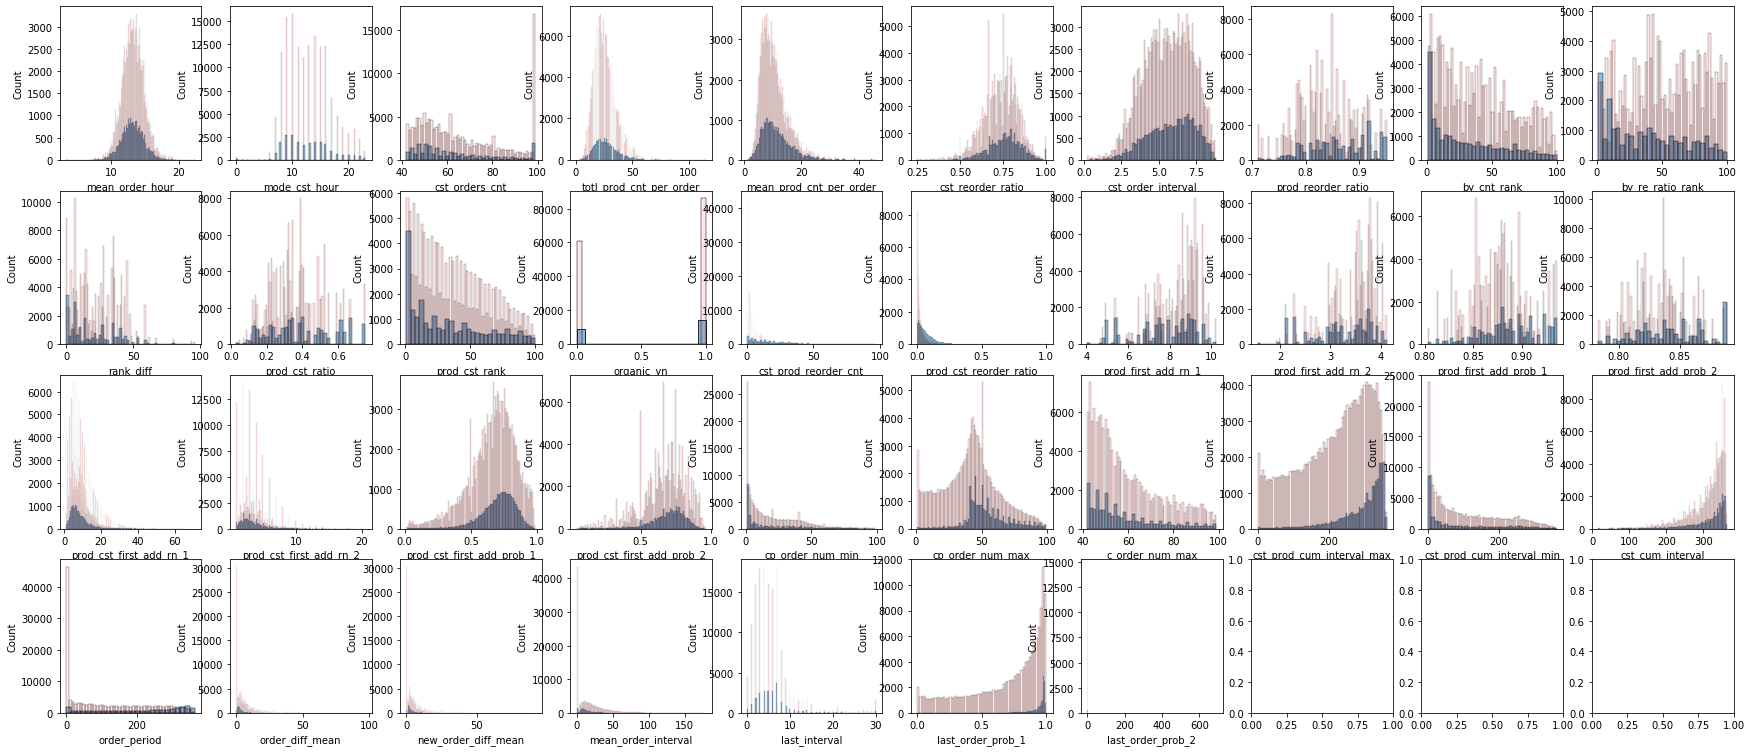

In [148]:
fig, axes = plt.subplots(nrows=4, ncols = 10, figsize = (30,13))

for i, col_name in enumerate(final_y.columns):
    row = i // 10
    col = i  % 10
    sns.histplot(final_y[col_name], ax = axes[row][col], alpha = 0.5, label = 'y')
    sns.histplot(final_n[col_name], ax = axes[row][col], color = 'red', alpha = 0.1, label = 'n')

In [149]:
# fitting_col_list = ['cstno','product_id', 'cst_prod_reorder_cnt',
#        'prod_cst_reorder_ratio', 'prod_first_add_rn_1', 'prod_first_add_rn_2',
#        'prod_first_add_prob_1', 'prod_first_add_prob_2',
#        'prod_cst_first_add_rn_1', 'prod_cst_first_add_rn_2',
#        'prod_cst_first_add_prob_1', 'prod_cst_first_add_prob_2',
#        'cp_order_num_min', 'cp_order_num_max', 'c_order_num_max',
#        'cst_prod_cum_interval_max', 'cst_prod_cum_interval_min',
#        'cst_cum_interval', 'order_period', 'order_diff_mean',
#        'new_order_diff_mean', 'mean_order_interval', 'last_interval',
#        'last_order_prob_1', 'last_order_prob_2','final_reorder_yn']
fitting_col_list = ['cstno', 'product_id', 'cst_prod_reorder_cnt', 'prod_cst_reorder_ratio','cp_order_num_max', 'order_period','mean_order_interval','last_order_prob_1', 'final_reorder_yn']

In [150]:
fitting_df = feature_info[fitting_col_list].copy()

## 3.2. train / validation set split

- 기존 train 고객 5859명을 train set과 validation set으로 나누고자 함 (8:2)
- 한 고객에 대한 정보는 한 그룹으로 묶어서 split 해야하기 때문에, 수동으로 validation set을 나눠주려함

In [151]:
total_cst = fitting_df['cstno'].nunique()
partition = []

for i in range(0, 5):
    partition.append(math.floor(0.2*(i+1)*total_cst))

In [152]:
partition

[1171, 2343, 3515, 4687, 5859]

In [153]:
def split_cst(i):
    if i == 5:
        train_cstno = fitting_df['cstno'].unique()[:partition[i-2]]
        val_cstno = fitting_df['cstno'].unique()[partition[i-2]:]
    elif i == 1:
        train_cstno = fitting_df['cstno'].unique()[partition[i-1]:]
        val_cstno = fitting_df['cstno'].unique()[:partition[i-1]]                                                   
    else:
        train_cstno = np.concatenate((fitting_df['cstno'].unique()[:partition[i-2]],fitting_df['cstno'].unique()[partition[i-1]:]), axis=0)
        val_cstno = fitting_df['cstno'].unique()[partition[i-2]:partition[i-1]]
    
    return train_cstno, val_cstno

# print(train_cstno, len(train_cstno))
# print(val_cstno, len(val_cstno))

In [154]:
train_cstno, val_cstno = split_cst(5)
print("train cst: ", len(train_cstno), "val cst: ", len(val_cstno))

train cst:  4687 val cst:  1172


In [155]:
#혹시 val_cstno와 train_cstno의 동일한 id값이 포함되어 있는지 확인
print(set(val_cstno) == set(train_cstno))

False


In [156]:
train_set = fitting_df[fitting_df['cstno'].isin(train_cstno)]
validation_set = fitting_df[fitting_df['cstno'].isin(val_cstno)]

print(len(train_set), len(validation_set))

146225 23973


In [157]:
x_train = train_set.iloc[:,2:-1]
y_train = train_set.iloc[:,-1]

x_test = validation_set.iloc[:,2:-1]
y_test = validation_set.iloc[:,-1]

## 3.3. 모델별 hyper parameter 설정

In [158]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel):
    '''하이퍼파라미터 별 모델 성능 시각화'''
    #하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle='-', label = 'train_score')
    
    #하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델성능 추이 시각화
    plt.plot(x_values, test_score, linestyle='--', label = 'test_score')
    
    plt.ylabel('Accuracy(%)')
    plt.xlabel(xlabel)
    plt.legend()

In [159]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    '''트리모델 갯수 선정'''
    train_score = []
    test_score = []
    para_n_tree = [n_tree * 5 for n_tree in range(n_estimator_min, n_estimator_max)]
    
     # XGBClassifier(eval_metric = 'mlogloss', use_label_encoder = False)
    
    for v_n_estimators in para_n_tree:
        if algorithm_name == 'XGBC':
            model = algorithm(eval_metric = 'mlogloss', n_estimators = v_n_estimators, random_state = 1234)        
        else:    
            model = algorithm(n_estimators = v_n_estimators, random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        
    #트리 갯수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore':test_score})
    df_score_n['diff'] = df_score_n['TrainScore'] -  df_score_n['TestScore']
    #트리 갯수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name,para_n_tree, train_score, test_score, 'The number of estimators')
    print(round(df_score_n,4))

In [160]:
def optimi_maxdepth(algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    '''최대깊이 선정'''
    train_score = []
    test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]
    
    for v_max_depth in para_depth:
        if algorithm_name == 'XGBC':
            model = algorithm(eval_metric = 'mlogloss', max_depth = v_max_depth, n_estimators = n_estimator, random_state = 1234)
        else:
            model = algorithm(max_depth = v_max_depth, n_estimators = n_estimator, random_state = 1234)
        model.fit(x_train, y_train)
        
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    
    #최대깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth':para_depth, 'TrainScore':train_score, 'TestScore':test_score})
    df_score_n['diff'] = df_score_n['TrainScore'] -  df_score_n['TestScore']
    #최대깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, 'The number of depth')
    print(round(df_score_n,4))

In [161]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    '''분리 노드의 최소 자료 수 선정'''
    train_score = []
    test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    
    for v_min_samples_split in para_split:
        if algorithm_name == 'XGBC':
            model = algorithm(eval_metric = 'mlogloss', min_samples_split = v_min_samples_split, n_estimators = n_estimator, max_depth = n_depth, random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split, n_estimators = n_estimator, max_depth = n_depth, random_state = 1234)
        model.fit(x_train, y_train)
        
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        
    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    df_score_n['diff'] = df_score_n['TrainScore'] -  df_score_n['TestScore']
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, 'The minimum number of samples required to split an internal node')
    print(round(df_score_n, 4))

In [162]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    '''잎사귀노드의 최소 자료수 선정'''
    train_score = []
    test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        if algorithm_name == 'XGBC':
            model = algorithm(eval_metric = 'mlogloss', min_samples_leaf = v_min_samples_leaf, n_estimators = n_estimator, max_depth = n_depth, min_samples_split = n_split, random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf, n_estimators = n_estimator, max_depth = n_depth, min_samples_split = n_split, random_state=1234)

        model.fit(x_train, y_train)        
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    df_score_n['diff'] = df_score_n['TrainScore'] -  df_score_n['TestScore']
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, 'The minimum number of samples required to be at a leaf node')
    print(round(df_score_n, 4))

### 3.3.1. Random Forest

In [163]:
# 랜덤포레스트 분류 알고리즘
algorithm = RandomForestClassifier
algorithm_name = 'rfc'

    n_estimators  TrainScore  TestScore    diff
0              5      0.9788     0.8573  0.1215
1             10      0.9838     0.8709  0.1129
2             15      0.9922     0.8700  0.1222
3             20      0.9923     0.8734  0.1188
4             25      0.9951     0.8738  0.1213
5             30      0.9950     0.8755  0.1195
6             35      0.9961     0.8753  0.1208
7             40      0.9960     0.8765  0.1195
8             45      0.9967     0.8757  0.1209
9             50      0.9966     0.8754  0.1212
10            55      0.9969     0.8755  0.1214
11            60      0.9969     0.8764  0.1205
12            65      0.9970     0.8761  0.1209
13            70      0.9970     0.8755  0.1216
14            75      0.9971     0.8749  0.1223
15            80      0.9971     0.8754  0.1218
16            85      0.9972     0.8752  0.1219
17            90      0.9972     0.8758  0.1214
18            95      0.9972     0.8759  0.1213
19           100      0.9972     0.8764 

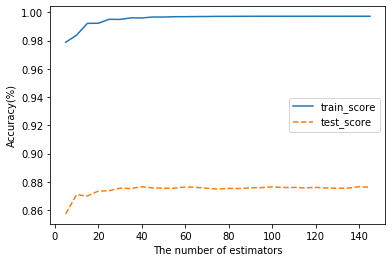

In [164]:
n_estimator_min = 1
n_estimator_max = 30

optimi_estimator(algorithm, algorithm_name,
                 x_train, y_train, x_test, y_test, 
                 n_estimator_min, n_estimator_max)

In [165]:
n_estimator_rfc_list = [30,35,40,45]
n_estimator = 40

    depth  TrainScore  TestScore    diff
0       1      0.8663     0.8565  0.0098
1       2      0.8726     0.8651  0.0076
2       3      0.8787     0.8744  0.0043
3       4      0.8793     0.8747  0.0046
4       5      0.8802     0.8764  0.0038
5       6      0.8823     0.8769  0.0054
6       7      0.8837     0.8780  0.0057
7       8      0.8857     0.8789  0.0067
8       9      0.8877     0.8779  0.0098
9      10      0.8910     0.8789  0.0122
10     11      0.8943     0.8796  0.0147
11     12      0.8991     0.8796  0.0195
12     13      0.9042     0.8797  0.0246
13     14      0.9115     0.8789  0.0325


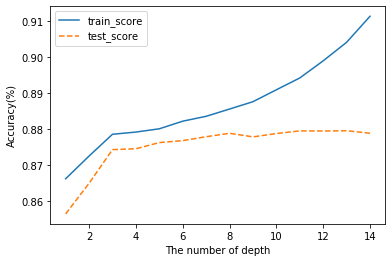

In [166]:
depth_min = 1
depth_max = 15
optimi_maxdepth(algorithm, algorithm_name,
                x_train, y_train, x_test, y_test,
               depth_min, depth_max, n_estimator)

In [167]:
n_depth_rfc_list = [4,5,6]
n_depth = 5

    min_samples_split  TrainScore  TestScore    diff
0                   2      0.8802     0.8764  0.0038
1                   4      0.8802     0.8764  0.0038
2                   6      0.8804     0.8762  0.0041
3                   8      0.8804     0.8762  0.0041
4                  10      0.8803     0.8763  0.0040
5                  12      0.8800     0.8757  0.0044
6                  14      0.8800     0.8757  0.0044
7                  16      0.8800     0.8757  0.0044
8                  18      0.8800     0.8757  0.0044
9                  20      0.8800     0.8757  0.0044
10                 22      0.8800     0.8757  0.0043
11                 24      0.8800     0.8757  0.0043
12                 26      0.8800     0.8757  0.0043
13                 28      0.8800     0.8757  0.0043
14                 30      0.8800     0.8757  0.0043
15                 32      0.8800     0.8757  0.0043
16                 34      0.8800     0.8757  0.0043
17                 36      0.8800     0.8757  

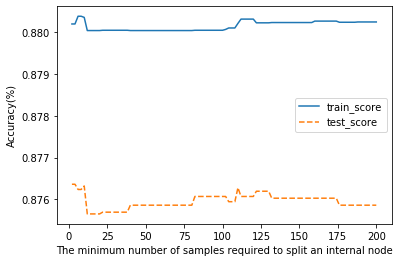

In [168]:
n_split_min = 1
n_split_max = 101

pd.set_option('display.max_row', 100)
optimi_minsplit(algorithm, algorithm_name,
               x_train, y_train, x_test, y_test,
               n_split_min, n_split_max, n_estimator, n_depth)

In [169]:
n_split_rfc_list = [40,42,44,82,84,86]
n_split = 82

    min_samples_leaf  TrainScore  TestScore    diff
0                  2      0.8802     0.8763  0.0039
1                  4      0.8802     0.8762  0.0040
2                  6      0.8802     0.8760  0.0042
3                  8      0.8802     0.8759  0.0043
4                 10      0.8802     0.8759  0.0043
5                 12      0.8802     0.8760  0.0042
6                 14      0.8802     0.8760  0.0042
7                 16      0.8802     0.8760  0.0042
8                 18      0.8802     0.8762  0.0040
9                 20      0.8802     0.8762  0.0040
10                22      0.8802     0.8762  0.0040
11                24      0.8802     0.8761  0.0041
12                26      0.8802     0.8761  0.0041
13                28      0.8802     0.8761  0.0041
14                30      0.8802     0.8761  0.0041
15                32      0.8804     0.8762  0.0043
16                34      0.8804     0.8762  0.0043
17                36      0.8804     0.8762  0.0043
18          

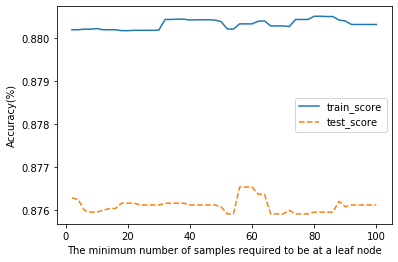

In [170]:
n_leaf_min = 1
n_leaf_max = 51

optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

In [171]:
n_leaf_rfc_list = [56,58,60,88,90,92]
n_leaf = 60

## 3.4. 모델 피팅 및 성능평가

### 3.4.1. Random Forest

In [172]:
st = datetime.now()
params = {
    'max_depth': n_depth_rfc_list,
    'min_samples_split': n_split_rfc_list,
    'n_estimators': n_estimator_rfc_list,
    'min_samples_leaf': n_leaf_rfc_list,
    'criterion' : ['entropy'],
    'bootstrap' : [True],
    'class_weight' : ['balanced_subsample'],
    'max_features' : ['auto'],
    'max_leaf_nodes' : [None],
    'warm_start' : [False]
    # 'oob_score' : [True]
}

model = RandomForestClassifier(random_state=1234) #randpm_state를 미리 모델에 지정
grid = GridSearchCV(model, param_grid=params, cv=5, refit=True, n_jobs= -1) 
grid.fit(x_train, y_train)

# n_depth_rfc, n_leaf_rfc, n_split_rfc, n_estimator_rfc = rand_clf.best_params_.values()
print(datetime.now() - st)

0:09:31.960964


In [173]:
print('훈련세트 정확도: {:.3f}'.format(grid.score(x_train, y_train)))
print('테스트 세트 정확도 : {:.2f}'.format(grid.score(x_test, y_test))) 
print('최적 매개변수 : {}'.format(grid.best_params_))
print('최상 교차 검증 점수 : {:.2f}'.format(grid.best_score_)) 
print('최고 성능 모델 : \n{}'.format(grid.best_estimator_)) 

results_rf = pd.DataFrame(grid.cv_results_)
display(results_rf.head())

훈련세트 정확도: 0.762
테스트 세트 정확도 : 0.76
최적 매개변수 : {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 92, 'min_samples_split': 40, 'n_estimators': 45, 'warm_start': False}
최상 교차 검증 점수 : 0.76
최고 성능 모델 : 
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, min_samples_leaf=92, min_samples_split=40,
                       n_estimators=45, random_state=1234)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.716880,2.740779,0.195057,0.074232,True,balanced_subsample,entropy,4,auto,None,56,40,30,False,"{'bootstrap': True, 'class_weight': 'balanced_...",0.720704,0.733869,0.767550,0.767516,0.784784,0.754885,0.023765,367
1,9.098731,3.049325,0.295185,0.058602,True,balanced_subsample,entropy,4,auto,None,56,40,35,False,"{'bootstrap': True, 'class_weight': 'balanced_...",0.720089,0.733014,0.768097,0.767037,0.788784,0.755404,0.025136,283
2,11.796390,1.227297,0.378312,0.091583,True,balanced_subsample,entropy,4,auto,None,56,40,40,False,"{'bootstrap': True, 'class_weight': 'balanced_...",0.714652,0.730074,0.772337,0.766216,0.789126,0.754481,0.027709,421
3,13.199295,2.076573,0.304828,0.083557,True,balanced_subsample,entropy,4,auto,None,56,40,45,False,"{'bootstrap': True, 'class_weight': 'balanced_...",0.714823,0.731783,0.774013,0.764678,0.790699,0.755199,0.027866,307
4,6.591619,1.488215,0.317193,0.146249,True,balanced_subsample,entropy,4,auto,None,56,42,30,False,"{'bootstrap': True, 'class_weight': 'balanced_...",0.720704,0.733869,0.767550,0.767516,0.784784,0.754885,0.023765,367




Precision: 0.344
Recall: 0.776
F1-score: 0.476

 confusion_matrix 
 [[15436  5098]
 [  770  2669]]


              precision    recall  f1-score   support

           0       0.95      0.75      0.84     20534
           1       0.34      0.78      0.48      3439

    accuracy                           0.76     23973
   macro avg       0.65      0.76      0.66     23973
weighted avg       0.87      0.76      0.79     23973



Feature importance: 
[0.28  0.155 0.122 0.034 0.03  0.379]


cst_prod_reorder_cnt: 0.280
prod_cst_reorder_ratio: 0.155
cp_order_num_max: 0.122
order_period: 0.034
mean_order_interval: 0.030
last_order_prob_1: 0.379




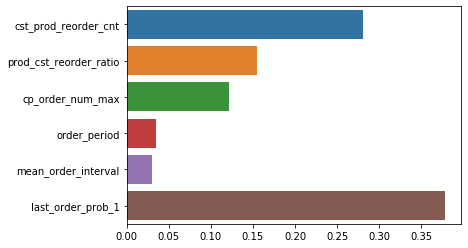

In [174]:
rand_clf = grid.best_estimator_
y_pred = rand_clf.predict(x_test)

print('\n')
print(f"Precision: {precision_score(y_test, y_pred, pos_label = '1'):.3f}") # 정밀도
print(f"Recall: {recall_score(y_test, y_pred, pos_label = '1'):.3f}") # 재현율
print(f"F1-score: {f1_score(y_test, y_pred, pos_label = '1'):.3f}") # F1 스코어

print('\n confusion_matrix \n', confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

print('\n')
print('Feature importance: \n{0}'.format(np.round(rand_clf.feature_importances_, 3)))
print('\n')
for name, value in zip(x_test.columns, rand_clf.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))
print('\n')

# plt.figure(figsize = (5,15))
sns.barplot(x = rand_clf.feature_importances_, y = x_test.columns)

<br>

#### 3.4.1.1. y_pred에 add_order 적용 테스트

In [175]:
pred_proba = rand_clf.predict_proba(x_test)

pred_proba = pd.DataFrame(pred_proba[:,1])
pred_proba.rename(columns = {0:'pred_proba'}, inplace= True)

rfc_result = pd.concat([x_test, y_test], axis = 1)
rfc_result.reset_index(inplace=True)

y_pred_df = pd.DataFrame(y_pred)
y_pred_df.rename(columns = {0:'final_pred'}, inplace = True)

rfc_result = pd.concat([rfc_result, y_pred_df], axis = 1)

In [176]:
rfc_result.head()

,index,cst_prod_reorder_cnt,prod_cst_reorder_ratio,cp_order_num_max,order_period,mean_order_interval,last_order_prob_1,final_reorder_yn,final_pred
0,9104,13,0.115702,40,220,15.785714,0.869091,0,1
1,9107,4,0.017182,37,113,22.800000,0.695055,0,0
2,9111,0,0.003906,80,0,1.000000,0.914754,0,0
3,9114,16,0.075556,50,96,5.705882,1.000000,0,1
4,9119,30,0.135965,67,288,9.322581,0.952239,1,1


In [177]:
pred_cst = validation_set.iloc[:,:2]
pred_cst.reset_index(inplace= True)

rfc_result = pd.concat([pred_cst, rfc_result],axis = 1)
rfc_result = pd.concat([rfc_result, pred_proba], axis = 1)

In [178]:
current_add_new = train_new_current.loc[train_new_current['is_reordered'] == '1'][['cstno','order_id','product_id','add_order']]
row_number(current_add_new, 'adj_add_order', 'add_order', True, ['cstno','order_id'])

rfc_result = rfc_result.merge(current_add_new[['cstno','product_id','adj_add_order']], on = ['cstno','product_id'], how = 'left')

In [179]:
rfc_result.head(3)

,index,cstno,product_id,index,cst_prod_reorder_cnt,prod_cst_reorder_ratio,cp_order_num_max,order_period,mean_order_interval,last_order_prob_1,final_reorder_yn,final_pred,pred_proba,adj_add_order
0,9104,5103,47209,9104,13,0.115702,40,220,15.785714,0.869091,0,1,0.540973,NaN
1,9107,141354,47209,9107,4,0.017182,37,113,22.800000,0.695055,0,0,0.278265,NaN
2,9111,164927,47209,9111,0,0.003906,80,0,1.000000,0.914754,0,0,0.228964,NaN


In [180]:
rfc_result['adj_add_order'] = rfc_result['adj_add_order'].fillna(0)
rfc_result.rename(columns = {'adj_add_order':'real_add_order'}, inplace = True)
type_change(rfc_result, 'real_add_order','int')

rfc_result = rfc_result.merge(feature_info[['cstno','product_id','prod_cst_first_add_prob_1', 'prod_cst_first_add_prob_2']], on = ['cstno','product_id'], how = 'left')

---
first_add_prob, pred_proba 등 전부 테스트 후 pred_proba 기준 내림차순이 가장 높은 f1_score가 나옴

In [181]:
row_number(rfc_result, 'pred_add_order','pred_proba', False, 'cstno')

rfc_result['pred_add_order'] = rfc_result['pred_add_order'].fillna(0)
rfc_result['pred_order_check'] =  rfc_result['real_add_order'] == rfc_result['pred_add_order']

rfc_tn = rfc_result.loc[(rfc_result['pred_order_check'] == True) & (rfc_result['real_add_order'] == 0) & (rfc_result['pred_add_order'] == 0)].count()[0]
rfc_fp = rfc_result.loc[(rfc_result['pred_order_check'] == False) & (rfc_result['real_add_order'] == 0) & (rfc_result['pred_add_order'] > 0)].count()[0]
rfc_fn = rfc_result.loc[(rfc_result['pred_order_check'] == False)].count()[0] - rfc_fp
rfc_tp = rfc_result.loc[(rfc_result['pred_order_check'] == True) & (rfc_result['real_add_order'] > 0) & (rfc_result['pred_add_order'] > 0)].count()[0]

rfc_recall = rfc_tp / (rfc_tp + rfc_fn)
rfc_precision = rfc_tp / (rfc_tp + rfc_fp)
rfc_f1 = 2*rfc_recall*rfc_precision/ (rfc_recall+rfc_precision)
print(rfc_f1)

print(rfc_tn, rfc_fp, rfc_fn, rfc_tp)
print(rfc_recall, rfc_precision)

0.0663036902601331
0 20534 2617 822
0.2390229717941262 0.038490353998876195


구매여부 1로 예측한 대상으로만 add_order를 설정했으나<br>
'1로 예측한 상품의 수 < current에 실제로 구매한 상품 수' 인 경우가 있어, 이를 반영하기 위해 1 / 0을 구분하지 않고 add_order를 설정함<br>
때문에 TN이 발생할 수 없어 중간 f1 score 는 낮게나옴<br>
위의 점수 중에서는 '재현율'이 가장 중요하므로 f1과 precision은 무시했음

### 3.4.2. 최종 f1_score 계산

> current data에 위에서 pred_proba 기준으로 설정한 add_order를 매칭하여 product 간의 f1_score 산출

In [182]:
current_copy = train_new_current[['cstno','product_id','is_reordered','add_order']].copy()
current_copy = current_copy.merge(current_add_new[['cstno','product_id','adj_add_order']], on = ['cstno','product_id'], how = 'left')

f1_test_cst = validation_set['cstno'].unique()
current_copy['adj_add_order'].fillna(0, inplace= True)

f1_test_df = current_copy.loc[current_copy['cstno'].isin(f1_test_cst)]
f1_test_df = pd.merge(left = f1_test_df, right = rfc_result.loc[rfc_result['final_pred'] == '1'][['cstno','pred_add_order', 'product_id']], left_on = ['cstno','adj_add_order'], right_on = ['cstno','pred_add_order'], how = 'left')

#train, test data에서 가장 구매가 많은 바나나를 test_past에 한 번도 구매하지 않은 고객이 42%이므로 전부 바나나로 대체.
f1_test_df.fillna('24852', inplace = True)

real_y_f1_test = f1_test_df['product_id_x']
pred_y_f1_test = f1_test_df['product_id_y']

print(f1_score(real_y_f1_test, pred_y_f1_test, average='micro'))

0.2222222222222222


### 3.4.3. 최적 파라미터로 전체 train set 학습

In [183]:
print('최적 매개변수 : {}'.format(grid.best_params_))

최적 매개변수 : {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 92, 'min_samples_split': 40, 'n_estimators': 45, 'warm_start': False}


In [324]:
final_rand_clf = RandomForestClassifier(bootstrap= True, class_weight= 'balanced_subsample', criterion= 'entropy'
                                        , max_depth= 6, max_features= 'auto', max_leaf_nodes= None, min_samples_leaf= 92
                                        , min_samples_split= 40, n_estimators= 45, warm_start= False, random_state=1234)

In [325]:
X_train = fitting_df.iloc[:,2:-1]
Y_train = fitting_df.iloc[:,-1]

In [370]:
final_rand_clf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, min_samples_leaf=92, min_samples_split=40,
                       n_estimators=45, random_state=1234)

---

# 4. test_data에 반영

## 4.1. test data 가공

### 4.1.1. 데이터타입 변경

In [371]:
test_x_past_copy = test_x_past.copy()
test_x_current_copy = test_x_current.copy()

In [372]:
test_x_past_copy.head(3)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,117004,186630,37,4,11,3.0,12,1,21709
1,128658,186630,20,2,10,6.0,4,1,21709
2,165882,186630,56,3,15,5.0,10,1,21709


In [373]:
test_x_past_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541922 entries, 0 to 541921
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   order_id        541922 non-null  object
 1   cstno           541922 non-null  object
 2   order_number    541922 non-null  object
 3   week_day        541922 non-null  object
 4   order_hour      541922 non-null  object
 5   order_interval  541922 non-null  object
 6   add_order       541922 non-null  object
 7   is_reordered    541922 non-null  object
 8   product_id      541922 non-null  object
dtypes: object(9)
memory usage: 37.2+ MB


In [374]:
type_change(test_x_past_copy, ['order_number','order_hour','add_order'], 'int')
type_change(test_x_current_copy, ['order_number','order_hour','add_order'], 'int')

In [375]:
test_x_past_copy['order_interval'] = pd.to_numeric(test_x_past_copy['order_interval'])
test_x_past_copy.loc[test_x_past_copy['order_number'] == 1, 'order_interval'] = -1

test_x_current_copy['order_interval'] = pd.to_numeric(test_x_current_copy['order_interval'])


type_change(test_x_past_copy, 'order_interval','int')
type_change(test_x_current_copy, 'order_interval','int')

### 4.1.2. 컬럼추가

In [376]:
test_x_past_copy['is_reordered_int'] = test_x_past_copy['is_reordered'].astype('int')

In [377]:
row_number(test_x_past_copy, 'new_add_order','add_order', True, ['cstno','order_number'])
row_number(test_x_current_copy, 'new_add_order','add_order', True, ['cstno','order_number'])

In [378]:
tmp_order_number_rn = test_x_past_copy[['cstno','order_id','order_number','add_order','new_add_order']].sort_values(['cstno','order_number','new_add_order'])
tmp_order_number_rn.reset_index(drop = True, inplace = True)

In [379]:
st = datetime.now()

new_orders = []
for idx, row in tmp_order_number_rn.iterrows():
    if idx == 0:
        new_order = 1
    elif prior_cstno != row['cstno']:
        new_order = 1
    elif prior_order_id == row['order_id']:
        new_order = prior_new_order_number
    else:
        new_order = prior_new_order_number + 1
    
    prior_cstno = row['cstno']
    prior_order_id = row['order_id']
    prior_new_order_number = new_order
    
    new_orders.append(new_order)

tmp_order_number_rn['new_order_number'] = new_orders    
print(datetime.now() - st)

0:00:35.974591


In [380]:
test_x_past_copy = pd.merge(left = test_x_past_copy, right = tmp_order_number_rn, how = 'left', on = ['cstno','order_id','order_number','add_order','new_add_order'])

In [381]:
del(tmp_order_number_rn)

## 4.2. 변수생성

'cst_prod_reorder_cnt','prod_cst_reorder_ratio','cp_order_num_max','order_period','mean_order_interval','last_order_prob_1'

In [382]:
test_feature_info = test_x_past_copy[['cstno','product_id']].value_counts()
test_feature_info = pd.DataFrame(test_feature_info)
test_feature_info.reset_index(inplace = True)
test_feature_info.drop(0,axis=1, inplace=True)

In [383]:
test_feature_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98203 entries, 0 to 98202
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cstno       98203 non-null  object
 1   product_id  98203 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


> 재구매횟수 - cst_prod_reorder_cnt

In [384]:
test_reorder_cnt = test_x_past_copy.groupby(['cstno','product_id'])['is_reordered_int'].sum()
test_reorder_cnt = pd.DataFrame(test_reorder_cnt)
test_reorder_cnt.reset_index(inplace = True)

test_reorder_cnt.rename(columns = {'is_reordered_int':'cst_prod_reorder_cnt'}, inplace = True)
test_feature_info = test_feature_info.merge(test_reorder_cnt, on = ['cstno','product_id'], how = 'left')

type_change(test_feature_info, 'cst_prod_reorder_cnt', 'int')

> 재구매율 - prod_cst_reorder_ratio

In [385]:
test_prod_cst_reorder_ratio = test_x_past_copy.groupby(['cstno','product_id'])['is_reordered_int'].sum() + 1

test_prod_cst_reorder_ratio = test_prod_cst_reorder_ratio /  test_prod_cst_reorder_ratio.groupby('cstno').sum()

test_prod_cst_reorder_ratio = pd.DataFrame(test_prod_cst_reorder_ratio)
test_prod_cst_reorder_ratio.reset_index(inplace = True)
test_prod_cst_reorder_ratio.rename(columns = {'is_reordered_int': 'prod_cst_reorder_ratio'}, inplace = True)

test_feature_info = test_feature_info.merge(test_prod_cst_reorder_ratio, on = ['cstno','product_id'], how = 'left')

> 고객+상품별 마지막 주문번호 - cp_order_num_max

In [386]:
test_cp_order_min = test_x_past_copy.groupby(['cstno','product_id'])['new_order_number'].min()
test_cp_order_max = test_x_past_copy.groupby(['cstno','product_id'])['new_order_number'].max()

In [387]:
test_c_order_max = test_cp_order_max.groupby('cstno').max()

In [388]:
test_cp_order_min = pd.DataFrame(test_cp_order_min)
test_cp_order_max = pd.DataFrame(test_cp_order_max)
test_c_order_max = pd.DataFrame(test_c_order_max)

test_cp_order_min.reset_index(inplace = True)
test_cp_order_max.reset_index(inplace = True)
test_c_order_max.reset_index(inplace = True)

test_cp_order_min.rename(columns = {'new_order_number':'cp_order_num_min'}, inplace = True)
test_cp_order_max.rename(columns = {'new_order_number':'cp_order_num_max'}, inplace = True)
test_c_order_max.rename(columns = {'new_order_number':'c_order_num_max'}, inplace = True)

In [389]:
test_feature_info = test_feature_info.merge(test_cp_order_min, on = ['cstno','product_id'], how ='left')
test_feature_info = test_feature_info.merge(test_cp_order_max, on = ['cstno','product_id'], how ='left')
test_feature_info = test_feature_info.merge(test_c_order_max, on = 'cstno', how ='left')

> 주문기간, 평균 주문간격 - order_period, mean_order_interval

In [390]:
test_recent_tmp = test_x_past_copy.loc[(test_x_past_copy['new_add_order'] == 1)].sort_values(['cstno','new_order_number'])[['cstno','order_id','new_order_number','order_interval']]
test_recent_tmp['cum_interval'] = test_recent_tmp.groupby('cstno')['order_interval'].cumsum()+1
test_recent_tmp.head(3)

,cstno,order_id,new_order_number,order_interval,cum_interval
370508,100041,386862,1,-1,0
269056,100041,1752031,2,14,14
269061,100041,2977636,3,13,27


In [391]:
test_recent_tmp = test_recent_tmp.merge(test_x_past_copy[['order_id','product_id']], on = 'order_id', how = 'left')

test_cum_max = test_recent_tmp.groupby (['cstno','product_id'])['cum_interval'].max()
test_cum_min = test_recent_tmp.groupby (['cstno','product_id'])['cum_interval'].min()
test_cst_max = test_recent_tmp.groupby ('cstno')['cum_interval'].max()

test_cum_max = pd.DataFrame(test_cum_max)
test_cum_min = pd.DataFrame(test_cum_min)
test_cst_max = pd.DataFrame(test_cst_max)

test_cum_max.reset_index(inplace = True)
test_cum_min.reset_index(inplace = True)
test_cst_max.reset_index(inplace = True)

In [392]:
test_cum_tmp = pd.merge(left = test_cum_max, right = test_cum_min, on = ['cstno','product_id'], how = 'left')
test_cum_tmp = test_cum_tmp.merge(test_cst_max, on = 'cstno', how = 'left')
test_cum_tmp.rename(columns = {'cum_interval_x':'cst_prod_cum_interval_max', 'cum_interval_y' : 'cst_prod_cum_interval_min', 'cum_interval':'cst_cum_interval'}, inplace = True)

test_cum_tmp['order_period'] = test_cum_tmp['cst_prod_cum_interval_max'] - test_cum_tmp['cst_prod_cum_interval_min']

In [393]:
test_feature_info = test_feature_info.merge(test_cum_tmp, on = ['cstno','product_id'], how = 'left')
test_feature_info['mean_order_interval'] = (test_feature_info['order_period']+1) / (test_feature_info['cst_prod_reorder_cnt']+1)

> 최근구매확률 - last_order_prob_1

In [394]:
test_feature_info = test_feature_info.merge(test_x_current_copy.loc[test_x_current_copy['new_add_order'] == 1][['cstno','order_interval']], on = ['cstno'], how = 'left')
test_feature_info.rename(columns = {'order_interval':'last_interval'}, inplace = True)

In [395]:
test_feature_info['last_order_prob_1'] = test_feature_info['cst_prod_cum_interval_max'] / (test_feature_info['cst_cum_interval'] + test_feature_info['last_interval'])

> 불필요한 컬럼 제거

In [396]:
final_test_data = test_feature_info.drop(['cp_order_num_min','c_order_num_max','cst_prod_cum_interval_max','cst_prod_cum_interval_min','cst_cum_interval','last_interval'], axis = 1)

In [397]:
final_test_data.head()

,cstno,product_id,cst_prod_reorder_cnt,prod_cst_reorder_ratio,cp_order_num_max,order_period,mean_order_interval,last_order_prob_1
0,115681,27845,40,0.506173,41,330,8.073171,0.973451
1,176777,24964,40,0.071181,41,350,8.560976,0.977654
2,2397,24852,40,0.931818,41,159,3.902439,0.987578
3,20930,24852,40,0.414141,41,265,6.487805,0.929825
4,129565,196,40,0.788462,41,328,8.024390,0.984985


In [398]:
X_test = final_test_data.iloc[:, 2:]

## 4.3. 모델에 적용

In [399]:
final_y_pred = final_rand_clf.predict(X_test)
final_pred_proba = final_rand_clf.predict_proba(X_test)

final_y_pred_df = pd.DataFrame(final_y_pred)
final_y_pred_df.rename(columns = {0:'final_pred'}, inplace = True)

final_pred_proba = pd.DataFrame(final_pred_proba[:,1])
final_pred_proba.rename(columns = {0:'pred_proba'}, inplace= True)

In [400]:
final_y = pd.concat([final_y_pred_df, final_pred_proba], axis = 1)
final_df = pd.concat([final_test_data.iloc[:,:2], final_y], axis = 1)

> 최종 재구매 1에 대해서만 add_order 생성

In [401]:
add_order_tmp = test_x_current_copy.loc[test_x_current_copy['is_reordered'] == '1'][['cstno','order_id','add_order']]
row_number(add_order_tmp, 'adj_add_order', 'add_order', True, ['cstno','order_id'])

test_x_current_copy = test_x_current_copy.merge(add_order_tmp, on = ['cstno','order_id','add_order'], how = 'left')

In [402]:
test_x_current_copy['adj_add_order'].fillna(0,inplace = True)

In [403]:
test_x_current_copy.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,new_add_order,adj_add_order
0,3384204,37987,38,5,16,13,9,1,4,4.0
1,2578612,169022,38,6,10,7,4,1,3,3.0
2,188887,200090,45,5,16,30,5,1,3,3.0
3,646772,149416,39,1,13,13,15,1,8,8.0
4,300214,113836,42,3,10,17,1,1,1,1.0


> pred_proba 기준으로 예측 데이터에 add_order 생성

In [404]:
row_number(final_df, 'add_order','pred_proba', False, 'cstno')

final_df['add_order'] = final_df['add_order'].fillna(0)
test_x_current_copy = pd.merge(left = test_x_current_copy, right = final_df[['cstno','add_order','product_id']], left_on=['cstno','adj_add_order'], right_on = ['cstno','add_order'], how = 'left')

> 신규상품의 Null 대체

    고객별 신규구매 매칭 후보상품들을 과거/현재에 전부 구매한 적이 없어야하므로 해당 부분을 체크하기위한 df 생성

In [405]:
new_product_df = test_feature_info[['cstno','product_id']]
new_product_df = pd.concat([new_product_df,test_x_current_copy[['cstno','product_id']]], axis = 0)

new_product_df.shape

(114329, 2)

    1) 예측 상품 중 바나나가 없는 고객 - 바나나로 대체

In [406]:
banana_cst = new_product_df.loc[new_product_df['product_id'] == '24852']['cstno'].unique()

test_x_current_copy.loc[test_x_current_copy['cstno'].isin(banana_cst), 'new_yn'] = '1'
test_x_current_copy['new_yn'].fillna('0', inplace = True)

test_x_current_copy.loc[(test_x_current_copy['product_id'].isnull() == True) & (test_x_current_copy['new_yn'] == '0'), 'product_id'] = '24852'

    2) 예측 상품 중 바나나가 있는 고객 - train_current에서 최근에 가장 신규구매가 많았던 상품 순서대로 대체

In [407]:
tr_cr_prod = train_new_current.loc[train_new_current['is_reordered'] == '0'][['product_id','name']].value_counts()
tr_cr_prod = pd.DataFrame(tr_cr_prod)
tr_cr_prod.reset_index(inplace = True)

In [408]:
tr_cr_prod.head()

,product_id,name,0
0,30391,Organic Cucumber,52
1,8424,Broccoli Crown,41
2,31717,Organic Cilantro,36
3,27966,Organic Raspberries,32
4,24184,Red Peppers,31


In [409]:
for i in range(tr_cr_prod.shape[0]):
    test_x_current_copy['new_yn'] = '0'
    
    new_cst = new_product_df.loc[new_product_df['product_id'] == tr_cr_prod.iloc[i,0]]['cstno'].unique()    
    test_x_current_copy.loc[test_x_current_copy['cstno'].isin(new_cst), 'new_yn'] = '1'
    
    test_x_current_copy.loc[(test_x_current_copy['product_id'].isnull() == True) & (test_x_current_copy['new_yn'] == '0'), 'product_id'] = tr_cr_prod.iloc[i,0]
    
    null_check = test_x_current_copy['product_id'].isnull().sum()

    if null_check == 0:
        print(tr_cr_prod.iloc[i,1])
        break
    else:
        print(null_check)
        pass

278
63
27
12
6
Asparagus


In [410]:
#필요없어진 컬럼 제거
test_x_current_copy.drop(['add_order_y','new_yn'], axis = 1, inplace = True)
test_x_current_copy.rename(columns = {'add_order_x':'add_order'}, inplace = True)

test_x_current_copy.shape

(16126, 11)

### 4.3.1. test_y생성

In [411]:
test_y = test_x_current.copy()
type_change(test_y,'add_order','int')
test_y = pd.merge(left = test_y, right = test_x_current_copy[['order_id','cstno','add_order','product_id']], on = ['order_id','cstno','add_order'], how = 'left')

test_y.shape

(16126, 9)

In [412]:
test_y = test_y.iloc[:,-1]

In [413]:
test_y.to_csv('./test_y.csv')